# Sentinel-1 and Sentinel-2 Data Fusion using MOGPR

This notebook demonstrates how to:
1. Load Sentinel-1 (SAR) and Sentinel-2 (optical) time series data
2. Apply MOGPR (Multi-Output Gaussian Process Regression) fusion
3. Extract phenological metrics from fused data


## 1. Import Required Libraries

## 2. Data Generation and Loading

For this tutorial, we'll create synthetic S1 and S2 time series data. In practice, you would load your actual GeoTIFF stacks or data from other sources.

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# FuseTS imports
from fusets.mogpr import MOGPRTransformer
from fusets.analytics import phenology
from fusets import whittaker

print("Libraries imported successfully!")

Libraries imported successfully!


## 3. Generate Synthetic Data (Option B - For Testing Only)

**Skip this section if you loaded GEE Assets above!**

This section generates synthetic time series for demonstration purposes. Only run this if `USE_GEE_ASSETS=False`.

## 3. Prepare Data for MOGPR Processing

In [ ]:
# Only run this cell if NOT using GEE Assets
if not USE_GEE_ASSETS or gee_dataset is None:
    
    def generate_synthetic_timeseries(start_date='2023-01-01', end_date='2023-12-31', 
                                    spatial_size=(50, 50), temporal_freq='5D'):
        """
        Generate synthetic S1 and S2 time series data for demonstration
        """
        # Create time index
        time_index = pd.date_range(start_date, end_date, freq=temporal_freq)
        n_times = len(time_index)
        
        # Spatial coordinates
        y_coords = np.arange(spatial_size[0])
        x_coords = np.arange(spatial_size[1])
        
        # Generate synthetic seasonal patterns
        day_of_year = np.array([t.dayofyear for t in time_index])
        
        # Base seasonal cycle (simulating vegetation growth)
        seasonal_cycle = 0.5 * (1 + np.sin(2 * np.pi * (day_of_year - 80) / 365))
        
        # Generate S2 NDVI (optical, weather dependent - more gaps)
        s2_ndvi = np.zeros((n_times, spatial_size[0], spatial_size[1]))
        for i, y in enumerate(y_coords):
            for j, x in enumerate(x_coords):
                # Add spatial variability
                spatial_factor = 0.3 + 0.7 * np.sin(y/10) * np.cos(x/10)
                
                # Base NDVI with seasonal pattern
                base_ndvi = 0.2 + 0.6 * seasonal_cycle * spatial_factor
                
                # Add noise
                noise = np.random.normal(0, 0.05, n_times)
                s2_ndvi[:, i, j] = base_ndvi + noise
                
                # Simulate cloud gaps (20% missing data)
                cloud_mask = np.random.random(n_times) < 0.2
                s2_ndvi[cloud_mask, i, j] = np.nan
        
        # Generate S1 VV data (SAR - weather independent, correlated with vegetation)
        s1_vv = np.zeros((n_times, spatial_size[0], spatial_size[1]))
        for i, y in enumerate(y_coords):
            for j, x in enumerate(x_coords):
                spatial_factor = 0.3 + 0.7 * np.sin(y/10) * np.cos(x/10)
                
                # VV decreases with vegetation growth (volume scattering)
                base_vv = -15 - 5 * seasonal_cycle * spatial_factor
                noise = np.random.normal(0, 1.0, n_times)
                s1_vv[:, i, j] = base_vv + noise
        
        # Generate S1 VH data (cross-polarization)
        s1_vh = np.zeros((n_times, spatial_size[0], spatial_size[1]))
        for i, y in enumerate(y_coords):
            for j, x in enumerate(x_coords):
                spatial_factor = 0.3 + 0.7 * np.sin(y/10) * np.cos(x/10)
                
                # VH increases with vegetation growth
                base_vh = -25 + 3 * seasonal_cycle * spatial_factor
                noise = np.random.normal(0, 1.5, n_times)
                s1_vh[:, i, j] = base_vh + noise
        
        return time_index, y_coords, x_coords, s1_vv, s1_vh, s2_ndvi

    # Generate synthetic data
    print("Generating synthetic time series data...")
    time_idx, y_coords, x_coords, vv_data, vh_data, ndvi_data = generate_synthetic_timeseries()

    print(f"Generated data shapes:")
    print(f"Time series length: {len(time_idx)} observations")
    print(f"Spatial dimensions: {len(y_coords)} x {len(x_coords)} pixels")
    print(f"VV data shape: {vv_data.shape}")
    print(f"VH data shape: {vh_data.shape}")
    print(f"NDVI data shape: {ndvi_data.shape}")
else:
    print("✅ Using GEE Assets data - skipping synthetic data generation")

## 2. Load Data from GEE Assets (Real Data Required)

⚠️ **STOP! Assets don't exist yet?** Follow these steps first:

### 📋 Prerequisites: Export Data to GEE Assets First

**Before running this notebook, you must:**

1. **Open** `GEE_Data_Preparation_for_FuseTS_Assets.ipynb` 
2. **Run all cells** to export S1/S2 data to GEE Assets
3. **Wait for exports to complete** (check https://code.earthengine.google.com/tasks)
4. **Verify assets exist** at: `projects/ee-geodeticengineeringundip/assets/FuseTS/`

### 🔄 Export Status Check

Go to https://code.earthengine.google.com/tasks and ensure:
- ✅ All 31 period exports show "Completed" status
- ✅ Assets are visible in your GEE asset folder
- ✅ You have read permissions for the assets

### 📥 After Exports Complete

Once data is exported to GEE Assets:
1. Come back to this notebook
2. Set `USE_GEE_ASSETS = True` below
3. Run the data loading cell
4. Continue with MOGPR analysis

**Estimated export time:** 2-6 hours for full Java Island (depends on GEE queue)

### 🔍 Quick Check: Do Assets Exist?

Run this cell to verify your GEE Assets are ready:

In [2]:
# Quick check: Verify if GEE Assets exist
import ee

try:
    # Initialize GEE
    try:
        ee.Initialize(project='ee-geodeticengineeringundip')
    except:
        ee.Authenticate()
        ee.Initialize(project='ee-geodeticengineeringundip')
    
    # Check for individual assets (they're not a collection, but separate images)
    asset_base = 'projects/ee-geodeticengineeringundip/assets/FuseTS/S1_S2_Nov2024_Oct2025_Period_'
    
    # Try to load first few periods to verify
    found_periods = []
    missing_periods = []
    
    print("🔍 Checking for individual asset images...")
    for period in range(1, 32):  # Check all 31 periods
        asset_id = f'{asset_base}{period:02d}'
        try:
            img = ee.Image(asset_id)
            # Try to get info to verify it exists
            img.bandNames().getInfo()
            found_periods.append(period)
        except:
            missing_periods.append(period)
    
    print("="*70)
    if len(found_periods) > 0:
        print("✅ SUCCESS! GEE Assets found!")
        print("="*70)
        print(f"📊 Found {len(found_periods)}/31 period images")
        print(f"📁 Asset base: {asset_base}")
        print(f"   Example: {asset_base}01, {asset_base}02, ...")
        
        if len(missing_periods) > 0:
            print(f"\n⚠️  Missing {len(missing_periods)} periods: {missing_periods[:5]}{'...' if len(missing_periods) > 5 else ''}")
            print(f"   Check export status at: https://code.earthengine.google.com/tasks")
        else:
            print(f"\n✅ All 31 periods complete!")
        
        print("\n✅ You can proceed with data loading below!")
        print("   The code will load these individual assets and combine them")
        print("="*70)
    else:
        raise Exception("No assets found")
    
except Exception as e:
    print("="*70)
    print("❌ ASSETS NOT FOUND")
    print("="*70)
    print(f"Error: {str(e)}")
    print("\n🔧 NEXT STEPS:")
    print("1. Open GEE_Data_Preparation_for_FuseTS_Assets.ipynb")
    print("2. Run all cells to export data to GEE Assets")
    print("3. Monitor exports at: https://code.earthengine.google.com/tasks")
    print("4. Wait for all 31 period exports to complete")
    print("5. Come back here and run this check again")
    print("\n⏱️  Export typically takes 2-6 hours for Java Island")
    print("="*70)

🔍 Checking for individual asset images...
✅ SUCCESS! GEE Assets found!
📊 Found 31/31 period images
📁 Asset base: projects/ee-geodeticengineeringundip/assets/FuseTS/S1_S2_Nov2024_Oct2025_Period_
   Example: projects/ee-geodeticengineeringundip/assets/FuseTS/S1_S2_Nov2024_Oct2025_Period_01, projects/ee-geodeticengineeringundip/assets/FuseTS/S1_S2_Nov2024_Oct2025_Period_02, ...

✅ All 31 periods complete!

✅ You can proceed with data loading below!
   The code will load these individual assets and combine them


### 🔍 Diagnostic: Check Asset Coverage

Run this to see the actual bounds of your exported assets:

In [ ]:
# Check the geographic extent of your assets
import ee

try:
    ee.Initialize(project='ee-geodeticengineeringundip')
except:
    ee.Authenticate()
    ee.Initialize(project='ee-geodeticengineeringundip')

# Load first period to check extent
asset_id = 'projects/ee-geodeticengineeringundip/assets/FuseTS/S1_S2_Nov2024_Oct2025_Period_01'
img = ee.Image(asset_id)

# Get bounds
bounds = img.geometry().bounds().getInfo()
coords = bounds['coordinates'][0]

print("="*70)
print("📍 ASSET GEOGRAPHIC EXTENT")
print("="*70)
print(f"Asset: {asset_id}")
print(f"\nBounds (WGS84):")
print(f"  West:  {min([c[0] for c in coords]):.4f}°E")
print(f"  East:  {max([c[0] for c in coords]):.4f}°E")
print(f"  South: {min([c[1] for c in coords]):.4f}°N")
print(f"  North: {max([c[1] for c in coords]):.4f}°N")

print(f"\n📊 Java Island Reference Coordinates:")
print(f"  Full Java: 105.0°E to 115.0°E, -8.8°N to -5.6°N")
print(f"  Western Java (Banten): ~105.0°E to 106.5°E")
print(f"  Central Java: ~106.5°E to 111.0°E")
print(f"  Eastern Java: ~111.0°E to 115.0°E")

# Check if western Java is included
west_bound = min([c[0] for c in coords])
if west_bound > 105.5:
    print(f"\n⚠️  WARNING: Western boundary at {west_bound:.4f}°E")
    print(f"   Missing western Java (should start around 105.0°E)")
    print(f"\n🔧 SOLUTION:")
    print(f"   1. Check java_island_mask.tif covers western regions")
    print(f"   2. Re-export with correct study area bounds")
    print(f"   3. Ensure export region includes longitude >= 105.0°E")
else:
    print(f"\n✅ Coverage looks good - includes western Java")

print("="*70)

# Visualize bounds on map
import folium
center_lat = (min([c[1] for c in coords]) + max([c[1] for c in coords])) / 2
center_lon = (min([c[0] for c in coords]) + max([c[0] for c in coords])) / 2

m = folium.Map(location=[center_lat, center_lon], zoom_start=7)

# Add asset bounds
folium.Polygon(
    locations=[(c[1], c[0]) for c in coords],
    color='blue',
    fill=True,
    fillColor='blue',
    fillOpacity=0.2,
    popup='Asset Coverage'
).add_to(m)

# Add reference points for Java regions
folium.Marker([center_lat, 105.5], popup='Western Java (Banten)', icon=folium.Icon(color='red')).add_to(m)
folium.Marker([center_lat, 109.0], popup='Central Java', icon=folium.Icon(color='green')).add_to(m)
folium.Marker([center_lat, 113.0], popup='Eastern Java', icon=folium.Icon(color='orange')).add_to(m)

print("\n🗺️  Interactive map generated below:")
display(m)

### 🔬 Check Actual Data Coverage (Not Just Bounds)

This will sample actual pixel values across Java to find missing data areas:

In [ ]:
# Sample actual pixel data across Java to check for missing regions
import ee
import numpy as np

try:
    ee.Initialize(project='ee-geodeticengineeringundip')
except:
    pass

print("="*70)
print("🔬 CHECKING ACTUAL DATA COVERAGE")
print("="*70)

# Load first period
asset_id = 'projects/ee-geodeticengineeringundip/assets/FuseTS/S1_S2_Nov2024_Oct2025_Period_01'
img = ee.Image(asset_id)

# Define sample points across Java (west to east)
sample_points = [
    {'name': 'Western Java (Banten)', 'lon': 105.5, 'lat': -6.5},
    {'name': 'West Java', 'lon': 107.0, 'lat': -6.8},
    {'name': 'Central Java', 'lon': 109.5, 'lat': -7.2},
    {'name': 'Central Java (Coast)', 'lon': 110.5, 'lat': -6.9},
    {'name': 'Eastern Java', 'lon': 112.5, 'lat': -7.5},
    {'name': 'East Java (Tip)', 'lon': 114.0, 'lat': -7.8},
]

print("\n📍 Sampling pixel values at key locations:")
print("-" * 70)

missing_regions = []
valid_regions = []

for point in sample_points:
    try:
        # Sample at this location
        sample = img.sample(
            region=ee.Geometry.Point([point['lon'], point['lat']]),
            scale=50,
            projection='EPSG:4326',
            geometries=True
        ).first()
        
        # Get values
        vv = sample.get('VV').getInfo()
        vh = sample.get('VH').getInfo()
        ndvi = sample.get('S2ndvi').getInfo()
        
        # Check if data exists
        if vv is None or vh is None or ndvi is None:
            status = "❌ NO DATA"
            missing_regions.append(point['name'])
            print(f"{status:15} {point['name']:25} ({point['lon']:.2f}°E, {point['lat']:.2f}°N)")
        else:
            status = "✅ HAS DATA"
            valid_regions.append(point['name'])
            print(f"{status:15} {point['name']:25} ({point['lon']:.2f}°E, {point['lat']:.2f}°N)")
            print(f"                   VV={vv:.2f} dB, VH={vh:.2f} dB, NDVI={ndvi:.3f}")
    
    except Exception as e:
        status = "❌ ERROR"
        missing_regions.append(point['name'])
        print(f"{status:15} {point['name']:25} ({point['lon']:.2f}°E, {point['lat']:.2f}°N)")
        print(f"                   Error: {str(e)[:50]}")

print("\n" + "="*70)
print("📊 SUMMARY")
print("="*70)
print(f"✅ Regions with data: {len(valid_regions)}/{len(sample_points)}")
if valid_regions:
    for region in valid_regions:
        print(f"   ✓ {region}")

if missing_regions:
    print(f"\n❌ Regions WITHOUT data: {len(missing_regions)}/{len(sample_points)}")
    for region in missing_regions:
        print(f"   ✗ {region}")
    
    print(f"\n🔧 ISSUE IDENTIFIED:")
    print(f"   The assets exist but don't contain actual pixel data for:")
    for region in missing_regions:
        print(f"   • {region}")
    
    print(f"\n💡 SOLUTION:")
    print(f"   This means the export process didn't capture data for these regions.")
    print(f"   Possible causes:")
    print(f"   1. Java Island mask doesn't cover these areas")
    print(f"   2. Export 'region' parameter was too restrictive")
    print(f"   3. No Sentinel data available for these locations during export")
    print(f"\n   Fix in GEE_Data_Preparation_for_FuseTS_Assets.ipynb:")
    print(f"   • Verify java_island_mask.tif covers ALL of Java")
    print(f"   • Check study_area geometry includes missing regions")
    print(f"   • Re-export with corrected mask/region")
else:
    print(f"\n✅ All sampled regions have data!")
    print(f"   If you still see missing areas, they may be:")
    print(f"   • Between sample points (try more samples)")
    print(f"   • Areas with genuine no-data (water, clouds, etc.)")

print("="*70)

## ⚠️ CRITICAL ISSUE: Most of Java Missing Data

Your assets exist but contain **NO ACTUAL PIXEL DATA** for most of Java Island. Only 2 out of 6 regions have data.

### 🔍 Root Cause Analysis

The export process created the assets with correct bounds, but didn't actually export the pixel values. This typically happens when:

1. **Java Island mask has holes** - The mask might have gaps where it should be solid
2. **Mask value is wrong** - Export used `mask > 0` but mask values might be different
3. **Region vs Mask conflict** - Both `region` and `mask` parameters were used incorrectly
4. **No data in source** - Sentinel data genuinely missing (unlikely for whole regions)

### 🔧 How to Fix This

**You MUST re-export the data. Follow these steps:**

#### Step 1: Verify the Mask File
Open `java_island_mask.tif` in QGIS/ArcGIS and check:
- ✓ Does it cover ALL of Java (no gaps in middle)?
- ✓ What are the pixel values? (should be 1 for Java, 0 for non-Java)
- ✓ Are there holes in the middle of the island?

#### Step 2: Fix the Export Code
Go to `GEE_Data_Preparation_for_FuseTS_Assets.ipynb` and modify the export:

**Current export likely has:**
```python
task = ee.batch.Export.image.toAsset(
    image=image_with_metadata.updateMask(java_mask),  # ← Problem here
    region=geometry,  # ← Or problem here
    ...
)
```

**Should be:**
```python
# Option A: Use mask properly
java_mask_binary = java_mask.gt(0)  # Ensure binary mask
masked_image = image_with_metadata.updateMask(java_mask_binary)

task = ee.batch.Export.image.toAsset(
    image=masked_image,
    region=java_geometry.bounds(),  # Use mask bounds, not separate region
    ...
)

# Option B: Export full region without mask (recommended for testing)
task = ee.batch.Export.image.toAsset(
    image=image_with_metadata,  # No mask - export everything
    region=ee.Geometry.Rectangle([105.0, -8.8, 115.0, -5.6]),  # Full Java bounds
    ...
)
```

#### Step 3: Delete Old Assets and Re-export
```javascript
// In GEE Code Editor or Python, delete the bad assets:
// Go to: https://code.earthengine.google.com
// Assets tab → FuseTS folder → Delete all Period_XX assets
```

Then re-run the export with fixed code.

### 📋 Quick Fix Checklist

- [ ] Open `java_island_mask.tif` and verify it's complete
- [ ] Open `GEE_Data_Preparation_for_FuseTS_Assets.ipynb`
- [ ] Find the export section (Cell 13)
- [ ] Check how mask is applied in export
- [ ] Delete old assets from GEE
- [ ] Re-export with corrected code
- [ ] Come back here and run the diagnostic again

**Do NOT continue with MOGPR analysis until this is fixed!** The current assets are unusable.

In [3]:
# ============================================================================
# OPTION A: Load Real Data from GEE Assets
# ============================================================================

import ee
import geemap
import xarray as xr
import rioxarray

# Configuration
USE_GEE_ASSETS = True  # Set to True to use GEE Assets, False for synthetic data
ASSET_BASE_PATH = 'projects/ee-geodeticengineeringundip/assets/FuseTS'
ASSET_NAME_PREFIX = 'S1_S2_Nov2024_Oct2025_Period_'  # Changed from pattern to prefix
NUM_PERIODS = 31  # Total number of periods to load
OUTPUT_LOCAL_DIR = 'gee_assets_download'

# Region of interest (optional - download specific area)
# Set to None to use full extent from assets
# Your assets contain: Kabupaten Demak (~900 km²)
USE_SMALL_REGION = False  # Set False to use full asset extent (Demak), True for subset only
if USE_SMALL_REGION:
    # Example: Even smaller test region within Demak
    REGION = ee.Geometry.Rectangle([110.40, -6.95, 110.50, -6.85])  # ~10x10 km
    REGION_NAME = 'Demak_Test'
else:
    # Use full extent from assets (Kabupaten Demak)
    REGION = None
    REGION_NAME = 'Demak_Full'

SCALE = 50  # meters (must match your asset export resolution)

def initialize_gee():
    """Initialize Google Earth Engine"""
    try:
        ee.Initialize(project='ee-geodeticengineeringundip')
        print("✅ Earth Engine initialized")
    except Exception as e:
        print(f"Initializing Earth Engine...")
        try:
            ee.Authenticate()
            ee.Initialize(project='ee-geodeticengineeringundip')
            print("✅ Earth Engine authenticated and initialized")
        except Exception as e2:
            print(f"❌ Error: {e2}")
            raise

def load_gee_assets_to_xarray(asset_base_path, name_prefix, num_periods=31, region=None, scale=50):
    """
    Load individual GEE Asset images and convert to xarray Dataset compatible with FuseTS
    
    Parameters:
    -----------
    asset_base_path : str
        Base path to GEE assets folder
    name_prefix : str
        Prefix for asset names (e.g., 'S1_S2_Nov2024_Oct2025_Period_')
    num_periods : int
        Number of periods to load (default 31)
    region : ee.Geometry, optional
        Region to download. If None, uses full asset extent
    scale : int
        Resolution in meters
        
    Returns:
    --------
    xr.Dataset with proper FuseTS format
    """
    import os
    import numpy as np
    from datetime import datetime, timedelta
    
    print(f"🔍 Loading {num_periods} individual assets from: {asset_base_path}/")
    print(f"   Asset name pattern: {name_prefix}01, {name_prefix}02, ...")
    
    # Create output directory
    os.makedirs(OUTPUT_LOCAL_DIR, exist_ok=True)
    
    # Storage for time series data
    all_vv = []
    all_vh = []
    all_ndvi = []
    time_coords = []
    
    # Load first asset to get spatial dimensions
    first_asset_id = f'{asset_base_path}/{name_prefix}01'
    first_img = ee.Image(first_asset_id)
    
    # Determine region from first asset if not specified
    if region is None:
        region = first_img.geometry().bounds()
        print(f"   Using full asset extent")
    
    # Get first image info
    bands = first_img.bandNames().getInfo()
    print(f"   Bands per period: {bands}")
    print(f"\n📥 Downloading {num_periods} periods at {scale}m resolution...")
    print(f"   This will take several minutes...")
    
    # Download each period individually
    for period in range(1, num_periods + 1):
        asset_id = f'{asset_base_path}/{name_prefix}{period:02d}'
        
        try:
            # Load asset
            img = ee.Image(asset_id)
            
            # Download this period
            output_file = os.path.join(OUTPUT_LOCAL_DIR, f'period_{period:02d}.tif')
            
            if not os.path.exists(output_file):
                print(f"   Downloading period {period}/{num_periods}...", end=' ')
                
                try:
                    geemap.download_ee_image(
                        img,
                        filename=output_file,
                        region=region,
                        scale=scale,
                        crs='EPSG:4326'
                    )
                    print("✓")
                except Exception as e:
                    print(f"✗ Failed: {e}")
                    continue
            else:
                print(f"   Period {period}/{num_periods}: Using cached file ✓")
            
            # Load the GeoTIFF
            period_data = rioxarray.open_rasterio(output_file)
            
            # Extract bands (assuming order: VV, VH, S2ndvi or NDVI)
            if len(period_data.band) >= 3:
                vv = period_data.isel(band=0).values  # First band = VV
                vh = period_data.isel(band=1).values  # Second band = VH
                ndvi = period_data.isel(band=2).values  # Third band = NDVI/S2ndvi
            else:
                print(f"   ⚠️  Period {period} has only {len(period_data.band)} bands, expected 3")
                continue
            
            all_vv.append(vv)
            all_vh.append(vh)
            all_ndvi.append(ndvi)
            
            # Calculate time coordinate (center of 12-day period starting Nov 1, 2024)
            start_date = datetime(2024, 11, 1)
            period_center = start_date + timedelta(days=(period-1)*12 + 6)
            time_coords.append(period_center)
            
            # Store spatial coords from first period
            if period == 1:
                y_coords = period_data.y.values
                x_coords = period_data.x.values
                
        except Exception as e:
            print(f"   ⚠️  Warning: Could not load period {period}: {e}")
    
    # Check if we got any data
    if len(all_vv) == 0:
        print("\n❌ No data loaded!")
        return None
    
    print(f"\n✅ Successfully loaded {len(all_vv)} periods")
    
    # Stack into numpy arrays
    vv_stack = np.stack(all_vv, axis=0)  # Shape: (time, y, x)
    vh_stack = np.stack(all_vh, axis=0)
    ndvi_stack = np.stack(all_ndvi, axis=0)
    
    # Create FuseTS-compatible xarray Dataset
    ds = xr.Dataset({
        'VV': (['t', 'y', 'x'], vv_stack),
        'VH': (['t', 'y', 'x'], vh_stack),
        'S2ndvi': (['t', 'y', 'x'], ndvi_stack)
    }, coords={
        't': time_coords,
        'y': y_coords,
        'x': x_coords
    })
    
    # Add metadata
    ds.attrs.update({
        'title': 'Sentinel-1/2 Time Series from GEE Assets',
        'source': f'{asset_base_path}/{name_prefix}',
        'temporal_resolution': '12-day composites',
        'spatial_resolution': f'{scale}m',
        'date_range': f'{time_coords[0].strftime("%Y-%m-%d")} to {time_coords[-1].strftime("%Y-%m-%d")}',
        'num_periods': len(time_coords),
        'region': 'Kabupaten Demak',
        'crs': 'EPSG:4326',
        'fusets_ready': True
    })
    
    print(f"\n📊 Dataset Summary:")
    print(f"   Shape: {ds.VV.shape} (time, y, x)")
    print(f"   Time range: {time_coords[0].strftime('%Y-%m-%d')} to {time_coords[-1].strftime('%Y-%m-%d')}")
    print(f"   Spatial extent: {len(y_coords)} x {len(x_coords)} pixels")
    print(f"   Bands: VV, VH, S2ndvi")
    
    return ds
    
    # Create ImageCollection from list
    collection = ee.ImageCollection(image_list)
    
    # Get collection info
    count = len(image_list)
    print(f"   Successfully loaded {count}/{num_periods} images")
    
    if count == 0:
        print("❌ No images found! Check:")
        print(f"   1. Asset path: {full_pattern}")
        print(f"   2. Asset permissions (must be readable)")
        print(f"   3. Export tasks completed successfully")
        return None
    
    # Get first image to check bands
    first = ee.Image(collection.first())
    bands = first.bandNames().getInfo()
    print(f"   Bands found: {bands}")
    
    # Determine region
    if region is None:
        region = collection.geometry().bounds()
        print(f"   Using full asset extent")
    else:
        print(f"   Using custom region: {region.bounds().getInfo()}")
    
    # Download collection as multi-band image
    print(f"\n📥 Downloading data at {scale}m resolution...")
    print(f"   This may take a few minutes depending on region size...")
    
    # Convert collection to multi-band image with period labels
    image_list = collection.toList(count)
    
    def add_period_suffix(image):
        img = ee.Image(image)
        period = ee.Number(img.get('period')).format('%02d')
        old_names = img.bandNames()
        new_names = old_names.map(lambda name: ee.String(name).cat('_P').cat(period))
        return img.rename(new_names).copyProperties(img, img.propertyNames())
    
    renamed_collection = collection.map(add_period_suffix)
    multi_band_image = renamed_collection.toBands()
    
    # Use geemap for efficient download
    import os
    os.makedirs(OUTPUT_LOCAL_DIR, exist_ok=True)
    
    output_file = os.path.join(OUTPUT_LOCAL_DIR, f'{REGION_NAME}_S1_S2_timeseries.tif')
    
    # Download using geemap
    try:
        geemap.download_ee_image(
            multi_band_image,
            filename=output_file,
            region=region,
            scale=scale,
            crs='EPSG:4326'
        )
        print(f"✅ Downloaded to: {output_file}")
    except Exception as e:
        print(f"⚠️  Direct download failed: {e}")
        print(f"   Trying alternative download method...")
        
        # Alternative: get download URL
        url = multi_band_image.getDownloadURL({
            'scale': scale,
            'crs': 'EPSG:4326',
            'region': region,
            'format': 'GEO_TIFF'
        })
        print(f"\n📎 Download URL generated:")
        print(f"   {url}")
        print(f"\n   Copy this URL to your browser to download the file")
        print(f"   Then save it as: {output_file}")
        print(f"   After download completes, re-run this cell to load the data")
        
        # Check if file exists from previous download
        if os.path.exists(output_file):
            print(f"\n✅ Found existing file: {output_file}")
        else:
            return None
    
    # Load the downloaded GeoTIFF
    print(f"\n📖 Loading GeoTIFF into xarray...")
    data_raster = rioxarray.open_rasterio(output_file)
    
    # Parse band names to extract periods and create proper dataset
    band_names = [str(b) for b in data_raster.band.values]
    print(f"   Total bands: {len(band_names)}")
    
    # Parse periods from band names (format: VV_P01, VH_P01, S2ndvi_P01, etc.)
    periods = sorted(list(set([int(b.split('_P')[1]) for b in band_names if '_P' in b])))
    n_periods = len(periods)
    print(f"   Periods found: {n_periods} ({min(periods)} to {max(periods)})")
    
    # Reorganize into proper time series format
    vv_data = []
    vh_data = []
    ndvi_data = []
    
    for period in periods:
        # Extract bands for this period
        vv_band = f'VV_P{period:02d}'
        vh_band = f'VH_P{period:02d}'
        ndvi_band = f'S2ndvi_P{period:02d}'
        
        # Find band indices
        vv_idx = [i for i, b in enumerate(band_names) if b.endswith(vv_band)]
        vh_idx = [i for i, b in enumerate(band_names) if b.endswith(vh_band)]
        ndvi_idx = [i for i, b in enumerate(band_names) if b.endswith(ndvi_band)]
        
        if vv_idx and vh_idx and ndvi_idx:
            vv_data.append(data_raster.isel(band=vv_idx[0]))
            vh_data.append(data_raster.isel(band=vh_idx[0]))
            ndvi_data.append(data_raster.isel(band=ndvi_idx[0]))
    
    # Stack into time dimension
    vv_array = xr.concat(vv_data, dim='time')
    vh_array = xr.concat(vh_data, dim='time')
    ndvi_array = xr.concat(ndvi_data, dim='time')
    
    # Create time coordinates (assuming 12-day periods starting Nov 1, 2024)
    from datetime import datetime, timedelta
    start_date = datetime(2024, 11, 1)
    time_coords = [start_date + timedelta(days=(p-1)*12 + 6) for p in periods]  # Center of each period
    
    # Create proper FuseTS-compatible dataset
    ds = xr.Dataset({
        'VV': (['time', 'y', 'x'], vv_array.values),
        'VH': (['time', 'y', 'x'], vh_array.values),
        'S2ndvi': (['time', 'y', 'x'], ndvi_array.values)
    }, coords={
        'time': time_coords,
        'y': vv_array.y.values,
        'x': vv_array.x.values
    })
    
    # Rename time dimension to 't' for FuseTS compatibility
    ds = ds.rename({'time': 't'})
    
    # Add metadata
    ds.attrs.update({
        'title': 'Sentinel-1/2 Time Series from GEE Assets',
        'source': f'{asset_base_path}/{name_prefix}',
        'temporal_resolution': '12-day composites',
        'spatial_resolution': f'{scale}m',
        'date_range': f'{time_coords[0].strftime("%Y-%m-%d")} to {time_coords[-1].strftime("%Y-%m-%d")}',
        'region': REGION_NAME,
        'crs': 'EPSG:4326',
        'fusets_ready': True
    })
    
    print(f"\n✅ Dataset created successfully!")
    print(f"   Shape: {ds.VV.shape}")
    print(f"   Time range: {time_coords[0]} to {time_coords[-1]}")
    print(f"   Spatial extent: {len(ds.y)} x {len(ds.x)} pixels")
    
    return ds

# Execute if using GEE Assets
if USE_GEE_ASSETS:
    print("="*70)
    print("🌍 LOADING DATA FROM GEE ASSETS")
    print("="*70)
    
    # Initialize GEE
    initialize_gee()
    
    # Load assets
    gee_dataset = load_gee_assets_to_xarray(
        ASSET_BASE_PATH,
        ASSET_NAME_PREFIX,
        num_periods=NUM_PERIODS,
        region=REGION,
        scale=SCALE
    )
    
    if gee_dataset is not None:
        print("\n" + "="*70)
        print("📊 DATASET SUMMARY")
        print("="*70)
        print(gee_dataset)
        print("\n✅ Data ready for MOGPR processing!")
        print("   Skip the synthetic data generation below and use 'gee_dataset'")
    else:
        print("\n⚠️  Failed to load GEE Assets")
        print("   Falling back to synthetic data generation...")
        USE_GEE_ASSETS = False
        
else:
    print("ℹ️  Using synthetic data (USE_GEE_ASSETS=False)")
    print("   To use GEE Assets, set USE_GEE_ASSETS=True above")
    gee_dataset = None

🌍 LOADING DATA FROM GEE ASSETS
✅ Earth Engine initialized
🔍 Loading 31 individual assets from: projects/ee-geodeticengineeringundip/assets/FuseTS/
   Asset name pattern: S1_S2_Nov2024_Oct2025_Period_01, S1_S2_Nov2024_Oct2025_Period_02, ...
   Using full asset extent
   Bands per period: ['VV', 'VH', 'S2ndvi']

📥 Downloading 31 periods at 50m resolution...
   This will take several minutes...
   Period 1/31: Using cached file ✓
   Period 2/31: Using cached file ✓
   Period 3/31: Using cached file ✓
   Period 4/31: Using cached file ✓
   Period 5/31: Using cached file ✓
   Period 6/31: Using cached file ✓
   Period 7/31: Using cached file ✓
   Period 8/31: Using cached file ✓
   Period 9/31: Using cached file ✓
   Period 10/31: Using cached file ✓
   Period 11/31: Using cached file ✓
   Period 12/31: Using cached file ✓
   Period 13/31: Using cached file ✓
   Period 14/31: Using cached file ✓
   Period 15/31: Using cached file ✓
   Period 16/31: Using cached file ✓
   Period 17/31: Using

## 📁 Alternative: Load GeoTIFF files directly

If you exported your data to GEE Drive as individual GeoTIFF files (period_01.tif, period_02.tif, etc.), use this function instead of the GEE Asset loader above.

In [ ]:
def load_geotiff_periods_to_xarray(geotiff_dir, num_periods=31, file_pattern='period_{:02d}.tif'):
    """
    Load individual GeoTIFF files (period_01.tif, period_02.tif, etc.) into xarray Dataset
    
    This function is for when you already have GeoTIFF files downloaded locally,
    either from GEE Drive export or downloaded manually.
    
    Parameters:
    -----------
    geotiff_dir : str
        Directory containing the GeoTIFF files
    num_periods : int
        Number of periods to load (default: 31)
    file_pattern : str
        Pattern for GeoTIFF filenames with {:02d} for zero-padded period number
        (default: 'period_{:02d}.tif')
    
    Returns:
    --------
    xarray.Dataset with dimensions (t, y, x) and variables (VV, VH, S2ndvi)
    """
    import os
    import rioxarray
    import numpy as np
    import xarray as xr
    from datetime import datetime, timedelta
    
    print(f"\n📁 Loading GeoTIFF files from: {geotiff_dir}")
    print(f"   Pattern: {file_pattern}")
    print(f"   Expected periods: {num_periods}")
    
    # Check if directory exists
    if not os.path.exists(geotiff_dir):
        print(f"❌ Directory not found: {geotiff_dir}")
        print(f"\n💡 Did you:")
        print(f"   1. Export from GEE to Drive?")
        print(f"   2. Download the files to your computer?")
        print(f"   3. Upload to HPC or Colab?")
        return None
    
    # Storage for time series data
    all_vv = []
    all_vh = []
    all_ndvi = []
    time_coords = []
    y_coords = None
    x_coords = None
    
    print(f"\n📥 Loading {num_periods} GeoTIFF files...")
    
    # Load each period
    loaded_count = 0
    for period in range(1, num_periods + 1):
        filename = file_pattern.format(period)
        filepath = os.path.join(geotiff_dir, filename)
        
        # Check if file exists
        if not os.path.exists(filepath):
            print(f"   ⚠️  Period {period:02d}: File not found: {filename}")
            continue
        
        try:
            # Load the GeoTIFF
            period_data = rioxarray.open_rasterio(filepath)
            
            # Extract bands (assuming order: VV, VH, S2ndvi or NDVI)
            num_bands = len(period_data.band)
            if num_bands >= 3:
                vv = period_data.isel(band=0).values  # First band = VV
                vh = period_data.isel(band=1).values  # Second band = VH
                ndvi = period_data.isel(band=2).values  # Third band = NDVI/S2ndvi
            elif num_bands == 1:
                # Single band - might be just NDVI
                print(f"   ⚠️  Period {period:02d}: Only 1 band found, treating as NDVI")
                ndvi = period_data.isel(band=0).values
                vv = np.full_like(ndvi, np.nan)
                vh = np.full_like(ndvi, np.nan)
            else:
                print(f"   ⚠️  Period {period:02d}: {num_bands} bands found, expected 3")
                continue
            
            all_vv.append(vv)
            all_vh.append(vh)
            all_ndvi.append(ndvi)
            
            # Calculate time coordinate (center of 12-day period starting Nov 1, 2024)
            start_date = datetime(2024, 11, 1)
            period_center = start_date + timedelta(days=(period-1)*12 + 6)
            time_coords.append(period_center)
            
            # Store spatial coords from first period
            if period == 1:
                y_coords = period_data.y.values
                x_coords = period_data.x.values
            
            loaded_count += 1
            if loaded_count % 5 == 0:
                print(f"   Loaded {loaded_count}/{num_periods} periods...")
                
        except Exception as e:
            print(f"   ⚠️  Period {period:02d}: Error loading {filename}: {e}")
    
    # Check if we got any data
    if len(all_vv) == 0:
        print("\n❌ No data loaded!")
        print(f"\n💡 Make sure GeoTIFF files are in: {geotiff_dir}")
        print(f"   Expected files: {file_pattern.format(1)}, {file_pattern.format(2)}, ...")
        return None
    
    print(f"\n✅ Successfully loaded {loaded_count}/{num_periods} periods")
    
    # Stack into numpy arrays
    vv_stack = np.stack(all_vv, axis=0)  # Shape: (time, y, x)
    vh_stack = np.stack(all_vh, axis=0)
    ndvi_stack = np.stack(all_ndvi, axis=0)
    
    # Create FuseTS-compatible xarray Dataset
    ds = xr.Dataset({
        'VV': (['t', 'y', 'x'], vv_stack),
        'VH': (['t', 'y', 'x'], vh_stack),
        'S2ndvi': (['t', 'y', 'x'], ndvi_stack)
    }, coords={
        't': time_coords,
        'y': y_coords,
        'x': x_coords
    })
    
    # Add metadata
    ds.attrs.update({
        'title': 'Sentinel-1/2 Time Series from GeoTIFF files',
        'source': geotiff_dir,
        'temporal_resolution': '12-day composites',
        'spatial_resolution': '50m',
        'date_range': f'{time_coords[0].strftime("%Y-%m-%d")} to {time_coords[-1].strftime("%Y-%m-%d")}',
        'num_periods': loaded_count,
        'region': 'Kabupaten Demak',
        'crs': 'EPSG:4326',
        'fusets_ready': True
    })
    
    print(f"\n📊 Dataset Summary:")
    print(f"   Shape: {ds.VV.shape} (time, y, x)")
    print(f"   Time range: {time_coords[0].strftime('%Y-%m-%d')} to {time_coords[-1].strftime('%Y-%m-%d')}")
    print(f"   Spatial extent: {len(y_coords)} x {len(x_coords)} pixels")
    print(f"   Bands: VV, VH, S2ndvi")
    print(f"   Total size: {ds.nbytes / 1e6:.1f} MB")
    
    return ds

### Usage Example: Load from Local GeoTIFF Files

If you have downloaded the GeoTIFF files to your local machine or HPC:

In [ ]:
# ============================================================================
# OPTION 1: Load from local GeoTIFF directory
# ============================================================================
# Use this if you have period_01.tif, period_02.tif, etc. downloaded locally

# Specify the directory containing your GeoTIFF files
GEOTIFF_DIR = '/path/to/your/geotiff/files'  # Change this to your actual path

# Examples:
# On HPC: GEOTIFF_DIR = '/home/username/data/demak_s1_s2'
# On local: GEOTIFF_DIR = '/Users/username/Downloads/demak_geotiffs'
# On Colab: GEOTIFF_DIR = '/content/drive/MyDrive/FuseTS_Data/demak'

# Load the data
combined_dataset = load_geotiff_periods_to_xarray(
    geotiff_dir=GEOTIFF_DIR,
    num_periods=31,
    file_pattern='period_{:02d}.tif'  # Adjust if your files have different naming
)

# Display the dataset
if combined_dataset is not None:
    print("\n" + "="*60)
    print("Dataset loaded successfully!")
    print("="*60)
    display(combined_dataset)

## 4. Visualize Input Data

### 📘 Quick Start Guide: Using GEE Assets

**Step 1: Export data to GEE Assets** (one-time setup)
- Run `GEE_Data_Preparation_for_FuseTS_Assets.ipynb`
- Set `EXPORT_DESTINATION = 'asset'`
- Monitor exports at https://code.earthengine.google.com/tasks
- Wait for all exports to complete (may take hours for Java Island)

**Step 2: Load data in this notebook**
- In Section 2 above, set `USE_GEE_ASSETS = True`
- Configure `ASSET_BASE_PATH` and `ASSET_PATTERN` to match your exports
- For testing: Set `USE_SMALL_REGION = True` to download only a small area
- For full analysis: Set `USE_SMALL_REGION = False` to use entire Java Island

**Step 3: Run MOGPR analysis**
- Execute cells below normally
- All code automatically uses either GEE or synthetic data
- Results will reflect the actual Indonesian agricultural calendar (Nov 2024 - Oct 2025)

**💡 Tips:**
- Start with small region for testing (faster download, ~1-2 minutes)
- Once validated, process full Java Island (may take longer, but stays in memory)
- Downloaded data is cached in `gee_assets_download/` folder for reuse
- You can change `REGION` to focus on specific areas of interest

In [4]:
def prepare_mogpr_dataset(s1_vv, s1_vh, s2_ndvi, time_coords, y_coords, x_coords):
    """
    Prepare properly formatted xarray Dataset for MOGPR processing
    (Only used for synthetic data)
    """
    
    # Create individual DataArrays with proper naming and coordinates
    vv_da = xr.DataArray(
        s1_vv,
        dims=['t', 'y', 'x'],  # Note: 't' dimension name is required by FuseTS
        coords={
            't': time_coords,
            'y': y_coords,
            'x': x_coords
        },
        name='VV',
        attrs={'long_name': 'Sentinel-1 VV backscatter', 'units': 'dB'}
    )
    
    vh_da = xr.DataArray(
        s1_vh,
        dims=['t', 'y', 'x'],
        coords={
            't': time_coords,
            'y': y_coords,
            'x': x_coords
        },
        name='VH',
        attrs={'long_name': 'Sentinel-1 VH backscatter', 'units': 'dB'}
    )
    
    ndvi_da = xr.DataArray(
        s2_ndvi,
        dims=['t', 'y', 'x'],
        coords={
            't': time_coords,
            'y': y_coords,
            'x': x_coords
        },
        name='S2ndvi',  # Specific naming required by MOGPR
        attrs={'long_name': 'Sentinel-2 NDVI', 'units': 'dimensionless'}
    )
    
    # Combine into Dataset
    dataset = xr.Dataset({
        'VV': vv_da,
        'VH': vh_da,
        'S2ndvi': ndvi_da
    })
    
    return dataset

# Prepare the dataset
print("Preparing dataset for MOGPR...")

if USE_GEE_ASSETS and gee_dataset is not None:
    # Use GEE Assets data (already in proper format)
    combined_dataset = gee_dataset
    print("✅ Using GEE Assets dataset")
else:
    # Use synthetic data
    combined_dataset = prepare_mogpr_dataset(
        vv_data, vh_data, ndvi_data,
        time_idx, y_coords, x_coords
    )
    print("✅ Using synthetic dataset")

print("\nDataset structure:")
print(combined_dataset)

# Check for missing data
print("\nMissing data summary:")
for var in combined_dataset.data_vars:
    missing_pct = (combined_dataset[var].isnull().sum() / combined_dataset[var].size * 100).values
    print(f"{var}: {missing_pct:.1f}% missing")

Preparing dataset for MOGPR...
✅ Using GEE Assets dataset

Dataset structure:
<xarray.Dataset> Size: 446MB
Dimensions:  (t: 31, y: 671, x: 893)
Coordinates:
  * t        (t) datetime64[ns] 248B 2024-11-07 2024-11-19 ... 2025-11-02
  * y        (y) float64 5kB -6.75 -6.75 -6.751 -6.751 ... -7.05 -7.05 -7.051
  * x        (x) float64 7kB 110.3 110.4 110.4 110.4 ... 110.7 110.7 110.7 110.8
Data variables:
    VV       (t, y, x) float64 149MB -inf -inf -inf -inf ... 0.0 0.0 0.0 0.0
    VH       (t, y, x) float64 149MB -inf -inf -inf -inf ... 0.0 0.0 0.0 0.0
    S2ndvi   (t, y, x) float64 149MB -inf -inf -inf -inf ... 0.0 0.0 0.0 0.0
Attributes:
    title:                Sentinel-1/2 Time Series from GEE Assets
    source:               projects/ee-geodeticengineeringundip/assets/FuseTS/...
    temporal_resolution:  12-day composites
    spatial_resolution:   50m
    date_range:           2024-11-07 to 2025-11-02
    num_periods:          31
    region:               Kabupaten Demak
    crs

## 4.5 GPU Detection and Configuration

Configure whether to use GPU-accelerated MOGPR (if available) or CPU version.

In [5]:
# ============================================================================
# GPU Detection and Configuration
# ============================================================================

USE_GPU = True  # Set to True if you have GPU and installed torch + gpytorch

if USE_GPU:
    try:
        import torch
        from fusets.mogpr_gpu import MOGPRTransformerGPU
        
        # Check GPU availability
        if torch.cuda.is_available():
            device = torch.device("cuda")
            gpu_name = torch.cuda.get_device_name(0)
            gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
            print(f"✅ GPU detected: {gpu_name}")
            print(f"   VRAM: {gpu_memory:.1f} GB")
            print(f"   CUDA version: {torch.version.cuda}")
        elif torch.backends.mps.is_available():
            device = torch.device("mps")
            print("✅ Apple Silicon GPU (MPS) detected")
        else:
            device = torch.device("cpu")
            print("⚠️  No GPU detected, falling back to CPU")
            USE_GPU = False
            
        if USE_GPU:
            print(f"\n🚀 GPU-accelerated MOGPR enabled!")
            print(f"   Expected speedup: 10-100x faster than CPU")
    except ImportError as e:
        print(f"⚠️  GPU libraries not available: {e}")
        print("   Falling back to CPU version")
        USE_GPU = False
else:
    print("ℹ️  Using CPU version of MOGPR")
    print("   To enable GPU: Set USE_GPU = True and install torch + gpytorch")

print(f"\nFinal configuration: {'GPU' if USE_GPU else 'CPU'} mode")

🚀 GPU detected: NVIDIA H100 80GB HBM3
✅ GPU detected: NVIDIA H100 80GB HBM3
   VRAM: 84.9 GB
   CUDA version: 12.4

🚀 GPU-accelerated MOGPR enabled!
   Expected speedup: 10-100x faster than CPU

Final configuration: GPU mode


## 5. Apply MOGPR Fusion

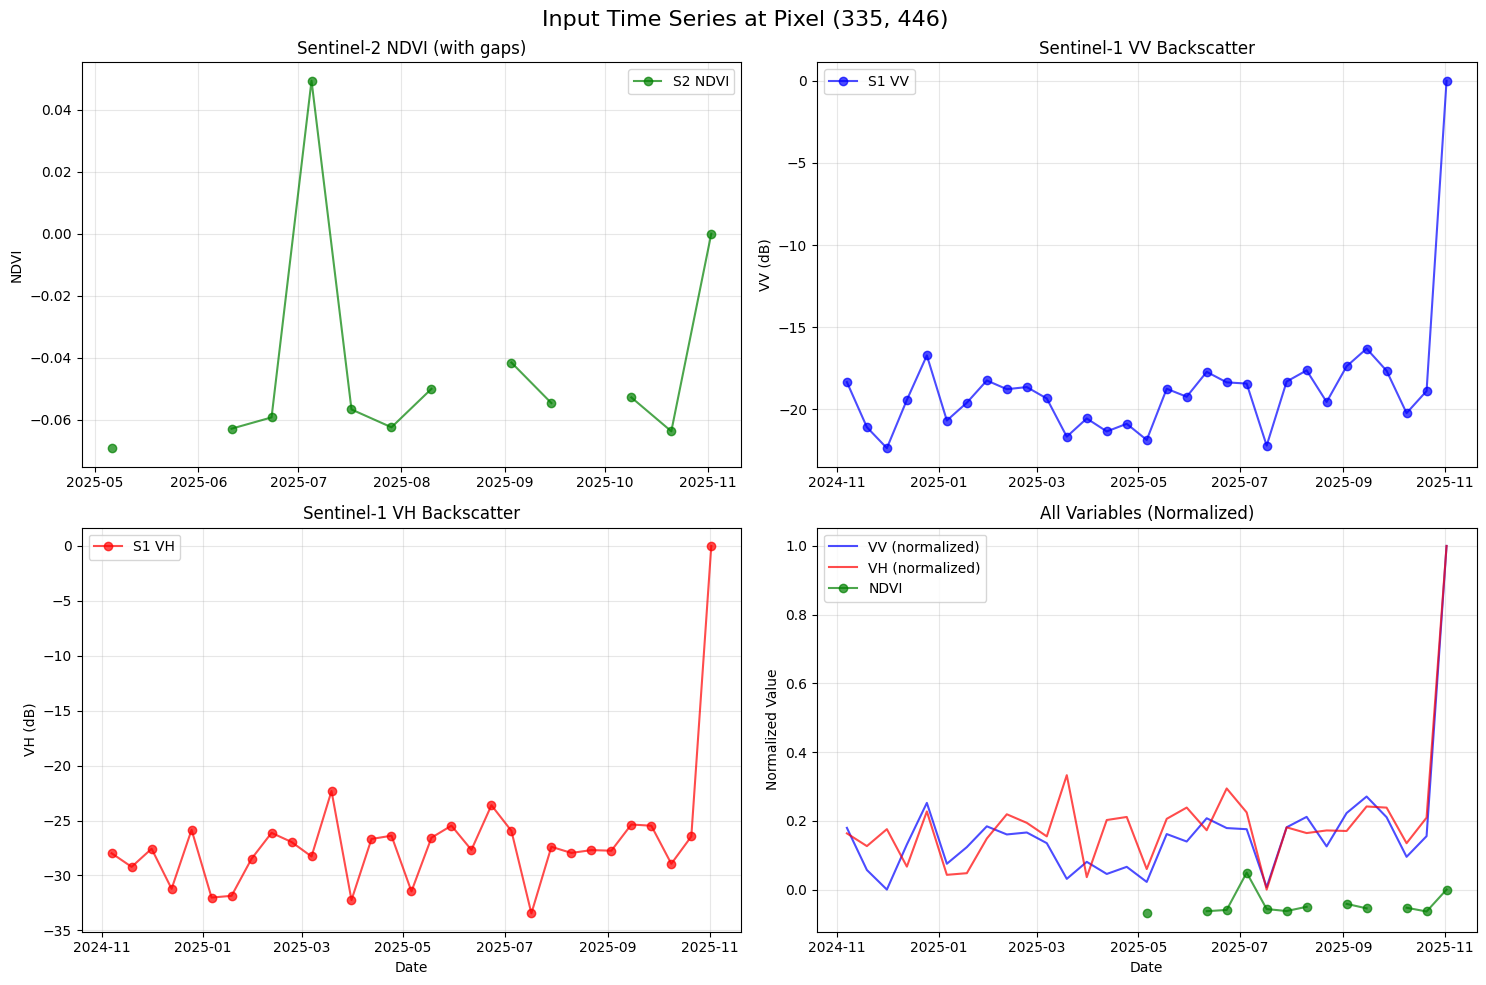

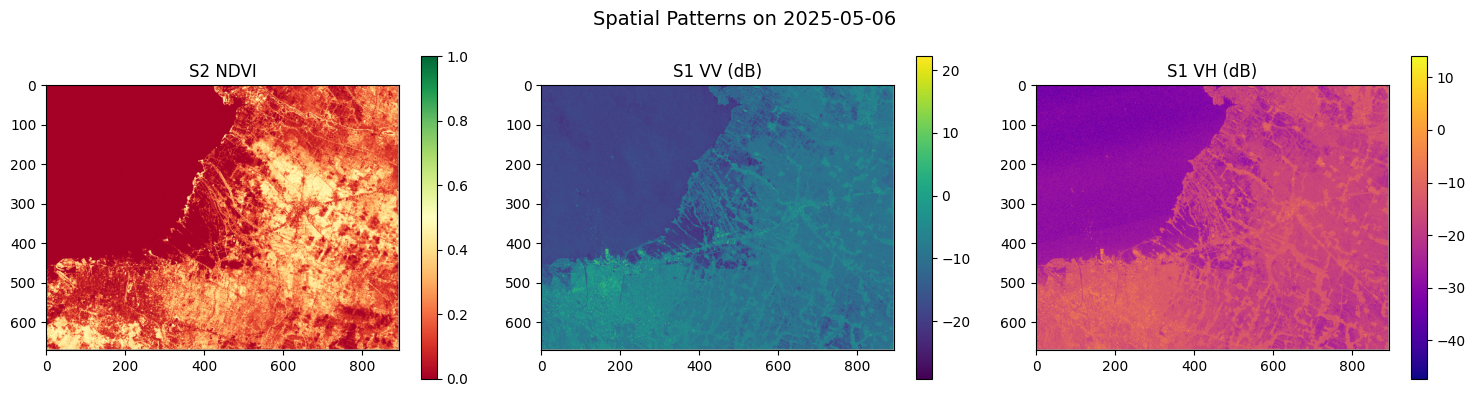

In [6]:
# Plot time series for a sample pixel
# Get dataset dimensions
n_time, n_y, n_x = combined_dataset['S2ndvi'].shape
sample_y, sample_x = n_y // 2, n_x // 2  # Center pixel
# Change to real paddyfield

# Get time coordinate
time_coord = combined_dataset.t.values

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle(f'Input Time Series at Pixel ({sample_y}, {sample_x})', fontsize=16)

# S2 NDVI
axes[0, 0].plot(time_coord, combined_dataset['S2ndvi'][:, sample_y, sample_x], 'go-', alpha=0.7, label='S2 NDVI')
axes[0, 0].set_title('Sentinel-2 NDVI (with gaps)')
axes[0, 0].set_ylabel('NDVI')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# S1 VV
axes[0, 1].plot(time_coord, combined_dataset['VV'][:, sample_y, sample_x], 'bo-', alpha=0.7, label='S1 VV')
axes[0, 1].set_title('Sentinel-1 VV Backscatter')
axes[0, 1].set_ylabel('VV (dB)')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

# S1 VH
axes[1, 0].plot(time_coord, combined_dataset['VH'][:, sample_y, sample_x], 'ro-', alpha=0.7, label='S1 VH')
axes[1, 0].set_title('Sentinel-1 VH Backscatter')
axes[1, 0].set_ylabel('VH (dB)')
axes[1, 0].set_xlabel('Date')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()

# All variables together
# Normalize for comparison
vv_norm = (combined_dataset['VV'][:, sample_y, sample_x] - combined_dataset['VV'][:, sample_y, sample_x].min()) / \
          (combined_dataset['VV'][:, sample_y, sample_x].max() - combined_dataset['VV'][:, sample_y, sample_x].min())
vh_norm = (combined_dataset['VH'][:, sample_y, sample_x] - combined_dataset['VH'][:, sample_y, sample_x].min()) / \
          (combined_dataset['VH'][:, sample_y, sample_x].max() - combined_dataset['VH'][:, sample_y, sample_x].min())
ndvi_norm = combined_dataset['S2ndvi'][:, sample_y, sample_x]

axes[1, 1].plot(time_coord, vv_norm, 'b-', alpha=0.7, label='VV (normalized)')
axes[1, 1].plot(time_coord, vh_norm, 'r-', alpha=0.7, label='VH (normalized)')
axes[1, 1].plot(time_coord, ndvi_norm, 'go-', alpha=0.7, label='NDVI')
axes[1, 1].set_title('All Variables (Normalized)')
axes[1, 1].set_ylabel('Normalized Value')
axes[1, 1].set_xlabel('Date')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Show spatial patterns at a specific date
mid_date_idx = len(time_coord) // 2
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle(f'Spatial Patterns on {time_coord[mid_date_idx].astype("datetime64[D]")}', fontsize=14)

im1 = axes[0].imshow(combined_dataset['S2ndvi'][mid_date_idx], cmap='RdYlGn', vmin=0, vmax=1)
axes[0].set_title('S2 NDVI')
plt.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(combined_dataset['VV'][mid_date_idx], cmap='viridis')
axes[1].set_title('S1 VV (dB)')
plt.colorbar(im2, ax=axes[1])

im3 = axes[2].imshow(combined_dataset['VH'][mid_date_idx], cmap='plasma')
axes[2].set_title('S1 VH (dB)')
plt.colorbar(im3, ax=axes[2])

plt.tight_layout()
plt.show()

## 6. Visualize Fusion Results

In [ ]:
# ⚠️ IMPORTANT: MOGPR is VERY SLOW on large areas!
# Create a small test subset to speed up processing
# This will reduce processing time from hours to minutes

print("Creating small test subset for faster MOGPR processing...")

# Extract a 50x50 pixel subset from the center
center_y = combined_dataset.dims['y'] // 2
center_x = combined_dataset.dims['x'] // 2
subset_size = 50

y_start = max(0, center_y - subset_size // 2)
y_end = min(combined_dataset.dims['y'], center_y + subset_size // 2)
x_start = max(0, center_x - subset_size // 2)
x_end = min(combined_dataset.dims['x'], center_x + subset_size // 2)

# Create subset
test_subset = combined_dataset.isel(y=slice(y_start, y_end), x=slice(x_start, x_end))

print(f"Original dataset size: {combined_dataset.dims}")
print(f"Test subset size: {test_subset.dims}")
print(f"Processing will be {(combined_dataset.dims['y'] * combined_dataset.dims['x']) / (test_subset.dims['y'] * test_subset.dims['x']):.0f}x faster!")
print("\n✅ Ready for MOGPR fusion")

### 🔍 Data Quality Check (Run this BEFORE MOGPR!)

**CRITICAL**: Check if your data is properly loaded and has valid values.

### ⚠️ URGENT: Check if combined_dataset exists and has data

**Run this BEFORE creating test_subset!**

In [5]:
# ============================================================================
# CRITICAL: Verify combined_dataset exists and has data
# ============================================================================

print("🔍 Checking if combined_dataset is loaded...\n")

# Check if variable exists
try:
    print(f"✅ combined_dataset exists")
    print(f"   Type: {type(combined_dataset)}")
    print(f"\n📊 Dataset structure:")
    print(combined_dataset)
    
    # Check data variables
    print(f"\n📈 Data variables:")
    for var in ['VV', 'VH', 'S2ndvi']:
        if var in combined_dataset:
            values = combined_dataset[var].values
            total = values.size
            nans = np.isnan(values).sum()
            valid = total - nans
            pct_valid = (valid / total) * 100
            
            print(f"\n{var}:")
            print(f"  Shape: {combined_dataset[var].shape}")
            print(f"  Valid: {valid:,} / {total:,} ({pct_valid:.1f}%)")
            
            if pct_valid == 0:
                print(f"  ❌ ALL NaN - NO DATA!")
            elif pct_valid < 10:
                print(f"  ⚠️  Very sparse data")
            else:
                valid_vals = values[~np.isnan(values)]
                print(f"  Range: [{valid_vals.min():.4f}, {valid_vals.max():.4f}]")
        else:
            print(f"\n❌ {var}: NOT FOUND in dataset!")
    
    # Final verdict
    print("\n" + "="*60)
    all_vars_empty = all(
        (combined_dataset[var].values if var in combined_dataset else np.array([np.nan])).size == np.isnan(
            combined_dataset[var].values if var in combined_dataset else np.array([np.nan])
        ).sum()
        for var in ['VV', 'VH', 'S2ndvi']
    )
    
    if all_vars_empty:
        print("❌ CRITICAL ERROR: Dataset is EMPTY (all NaN)!")
        print("="*60)
        print("\n🔧 YOU NEED TO:")
        print("1. Make sure GEOTIFF_DIR is set correctly")
        print("2. Re-run the data loading cell:")
        print("   combined_dataset = load_geotiff_periods_to_xarray(...)")
        print("3. Check that GeoTIFF files exist and have data")
    else:
        print("✅ Dataset has valid data - Ready to proceed!")
        print("="*60)
        
except NameError:
    print("❌ combined_dataset is NOT DEFINED!")
    print("\n🔧 YOU NEED TO:")
    print("1. Set GEOTIFF_DIR to your GeoTIFF directory")
    print("2. Run the cell that calls:")
    print("   combined_dataset = load_geotiff_periods_to_xarray(...)")
    print("\nExample:")
    print("   GEOTIFF_DIR = '/home/username/data/demak'")
    print("   combined_dataset = load_geotiff_periods_to_xarray(")
    print("       geotiff_dir=GEOTIFF_DIR,")
    print("       num_periods=31,")
    print("       file_pattern='period_{:02d}.tif'")
    print("   )")

🔍 Checking if combined_dataset is loaded...

✅ combined_dataset exists
   Type: <class 'xarray.core.dataset.Dataset'>

📊 Dataset structure:
<xarray.Dataset> Size: 446MB
Dimensions:  (t: 31, y: 671, x: 893)
Coordinates:
  * t        (t) datetime64[ns] 248B 2024-11-07 2024-11-19 ... 2025-11-02
  * y        (y) float64 5kB -6.75 -6.75 -6.751 -6.751 ... -7.05 -7.05 -7.051
  * x        (x) float64 7kB 110.3 110.4 110.4 110.4 ... 110.7 110.7 110.7 110.8
Data variables:
    VV       (t, y, x) float64 149MB -inf -inf -inf -inf ... 0.0 0.0 0.0 0.0
    VH       (t, y, x) float64 149MB -inf -inf -inf -inf ... 0.0 0.0 0.0 0.0
    S2ndvi   (t, y, x) float64 149MB -inf -inf -inf -inf ... 0.0 0.0 0.0 0.0
Attributes:
    title:                Sentinel-1/2 Time Series from GEE Assets
    source:               projects/ee-geodeticengineeringundip/assets/FuseTS/...
    temporal_resolution:  12-day composites
    spatial_resolution:   50m
    date_range:           2024-11-07 to 2025-11-02
    num_periods:

### 🔧 Fix: Replace -inf and invalid values with NaN

Your data contains `-inf` (negative infinity) values which break MOGPR. This cell will clean the data.

In [7]:
# ============================================================================
# Clean the dataset: Replace -inf, +inf, and zeros with NaN
# ============================================================================

print("🔧 Cleaning dataset: Replacing invalid values with NaN...\n")

# Make a copy to avoid modifying original
combined_dataset_clean = combined_dataset.copy()

for var in ['VV', 'VH', 'S2ndvi']:
    print(f"Processing {var}...")
    
    # Get values
    values = combined_dataset_clean[var].values
    
    # Count invalid values
    n_inf = np.isinf(values).sum()
    n_zero = (values == 0).sum()
    total = values.size
    
    print(f"  -inf/+inf values: {n_inf:,} ({n_inf/total*100:.1f}%)")
    print(f"  Zero values: {n_zero:,} ({n_zero/total*100:.1f}%)")
    
    # Replace -inf, +inf with NaN
    values_clean = np.where(np.isinf(values), np.nan, values)
    
    # For S2ndvi: Keep zeros (valid NDVI)
    # For VV/VH: Zeros might be valid backscatter, but check if they're fill values
    if var in ['VV', 'VH']:
        # If ALL non-inf values are zero, they're likely fill values
        non_inf = values_clean[~np.isnan(values_clean)]
        if non_inf.size > 0 and np.all(non_inf == 0):
            print(f"  ⚠️  All non-inf values are zero - treating as missing data")
            values_clean = np.where(values_clean == 0, np.nan, values_clean)
    
    # Update dataset
    combined_dataset_clean[var].values = values_clean
    
    # Report after cleaning
    valid_after = (~np.isnan(values_clean)).sum()
    print(f"  ✅ Valid values after cleaning: {valid_after:,} ({valid_after/total*100:.1f}%)\n")

# Replace the original dataset
combined_dataset = combined_dataset_clean

print("="*60)
print("✅ Dataset cleaned successfully!")
print("="*60)

# Show final statistics
print("\n📊 Final Data Quality:")
for var in ['VV', 'VH', 'S2ndvi']:
    values = combined_dataset[var].values
    valid = (~np.isnan(values)).sum()
    total = values.size
    pct_valid = valid / total * 100
    
    print(f"\n{var}:")
    print(f"  Valid: {valid:,} / {total:,} ({pct_valid:.1f}%)")
    
    if pct_valid > 0:
        valid_vals = values[~np.isnan(values)]
        print(f"  Range: [{valid_vals.min():.4f}, {valid_vals.max():.4f}]")
        print(f"  Mean: {valid_vals.mean():.4f}")
    else:
        print(f"  ❌ Still no valid data!")

# Check if we can proceed
print("\n" + "="*60)
any_valid = any(
    (~np.isnan(combined_dataset[var].values)).sum() > 0
    for var in ['VV', 'VH', 'S2ndvi']
)

if any_valid:
    print("✅ Dataset has valid data after cleaning!")
    print("   You can now proceed with MOGPR fusion.")
else:
    print("❌ CRITICAL: Still no valid data after cleaning!")
    print("\n💡 This means your GEE download failed or is corrupted.")
    print("   You need to:")
    print("   1. Check the GEE Assets in GEE Code Editor")
    print("   2. Re-download/re-export from GEE")
    print("   3. Or use the GeoTIFF loading method if you have local files")

print("="*60)

🔧 Cleaning dataset: Replacing invalid values with NaN...

Processing VV...
  -inf/+inf values: 93,720 (0.5%)
  Zero values: 599,203 (3.2%)
  ✅ Valid values after cleaning: 18,481,573 (99.5%)

Processing VH...
  -inf/+inf values: 93,720 (0.5%)
  Zero values: 599,203 (3.2%)
  ✅ Valid values after cleaning: 18,481,573 (99.5%)

Processing S2ndvi...
  -inf/+inf values: 11,274,758 (60.7%)
  Zero values: 599,920 (3.2%)
  ✅ Valid values after cleaning: 7,300,535 (39.3%)

✅ Dataset cleaned successfully!

📊 Final Data Quality:

VV:
  Valid: 18,481,573 / 18,575,293 (99.5%)
  Range: [-38.9679, 24.5295]
  Mean: -11.4048

VH:
  Valid: 18,481,573 / 18,575,293 (99.5%)
  Range: [-49.0673, 20.5313]
  Mean: -20.1266

S2ndvi:
  Valid: 7,300,535 / 18,575,293 (39.3%)
  Range: [-0.2125, 0.6029]
  Mean: 0.0943

✅ Dataset has valid data after cleaning!
   You can now proceed with MOGPR fusion.


In [8]:
# ============================================================================
# CRITICAL: Check data before running MOGPR
# ============================================================================

print("🔍 Checking data quality in test_subset...")
print(f"\nDataset structure:")
print(combined_dataset)

print(f"\n📊 Data Statistics:")
for var in ['VV', 'VH', 'S2ndvi']:
    values = combined_dataset[var].values
    valid_values = values[~np.isnan(values)]
    
    print(f"\n{var}:")
    print(f"  Shape: {values.shape}")
    print(f"  Total elements: {values.size:,}")
    print(f"  Valid values: {valid_values.size:,} ({valid_values.size/values.size*100:.1f}%)")
    print(f"  NaN values: {np.isnan(values).sum():,} ({np.isnan(values).sum()/values.size*100:.1f}%)")
    
    if valid_values.size > 0:
        print(f"  Range: [{valid_values.min():.4f}, {valid_values.max():.4f}]")
        print(f"  Mean: {valid_values.mean():.4f}")
    else:
        print(f"  ❌ ERROR: No valid values! All NaN!")

# Check if data is usable for MOGPR
print("\n" + "="*60)
print("MOGPR Requirements Check:")
print("="*60)

all_nan = {}
for var in ['VV', 'VH', 'S2ndvi']:
    values = combined_dataset[var].values
    pct_valid = (~np.isnan(values)).sum() / values.size * 100
    all_nan[var] = pct_valid == 0
    
    if pct_valid == 0:
        print(f"❌ {var}: 100% NaN - CANNOT RUN MOGPR!")
    elif pct_valid < 10:
        print(f"⚠️  {var}: Only {pct_valid:.1f}% valid - Poor quality")
    elif pct_valid < 50:
        print(f"⚠️  {var}: {pct_valid:.1f}% valid - Marginal quality")
    else:
        print(f"✅ {var}: {pct_valid:.1f}% valid - Good quality")

if any(all_nan.values()):
    print("\n" + "="*60)
    print("❌ CRITICAL ERROR: Some variables are completely empty!")
    print("="*60)
    print("\n💡 Possible causes:")
    print("   1. GeoTIFF files not properly loaded")
    print("   2. Wrong directory path in GEOTIFF_DIR")
    print("   3. Files exist but have no data")
    print("   4. Band indexing is wrong")
    print("\n🔧 Solutions:")
    print("   1. Check: print(list(GEOTIFF_DIR.glob('*.tif')))")
    print("   2. Verify GeoTIFF files have 3 bands (VV, VH, NDVI)")
    print("   3. Re-run the data loading cell")
    print("   4. Try loading one file manually to inspect")
else:
    print("\n✅ Data quality check passed! Ready for MOGPR.")

🔍 Checking data quality in test_subset...

Dataset structure:
<xarray.Dataset> Size: 446MB
Dimensions:  (t: 31, y: 671, x: 893)
Coordinates:
  * t        (t) datetime64[ns] 248B 2024-11-07 2024-11-19 ... 2025-11-02
  * y        (y) float64 5kB -6.75 -6.75 -6.751 -6.751 ... -7.05 -7.05 -7.051
  * x        (x) float64 7kB 110.3 110.4 110.4 110.4 ... 110.7 110.7 110.7 110.8
Data variables:
    VV       (t, y, x) float64 149MB nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    VH       (t, y, x) float64 149MB nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    S2ndvi   (t, y, x) float64 149MB nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    title:                Sentinel-1/2 Time Series from GEE Assets
    source:               projects/ee-geodeticengineeringundip/assets/FuseTS/...
    temporal_resolution:  12-day composites
    spatial_resolution:   50m
    date_range:           2024-11-07 to 2025-11-02
    num_periods:          31
    region:               Kabupaten Demak
    crs:   

### 🔍 Manual GeoTIFF Inspection

If the data quality check fails, use this to manually inspect your GeoTIFF files:

In [ ]:
# ============================================================================
# Manual inspection of GeoTIFF files (for debugging)
# ============================================================================
# Run this ONLY if data quality check fails

import os
from pathlib import Path

# Check if GEOTIFF_DIR is defined and exists
try:
    geotiff_path = Path(GEOTIFF_DIR)
    print(f"📁 Checking directory: {geotiff_path}")
    
    if not geotiff_path.exists():
        print(f"❌ Directory does not exist!")
        print(f"\n💡 Update GEOTIFF_DIR to point to your GeoTIFF files")
    else:
        # List all TIFF files
        tiff_files = sorted(geotiff_path.glob('*.tif'))
        print(f"\n✅ Found {len(tiff_files)} TIFF files:")
        for f in tiff_files[:5]:  # Show first 5
            print(f"   {f.name}")
        if len(tiff_files) > 5:
            print(f"   ... and {len(tiff_files)-5} more")
        
        # Load and inspect first file
        if len(tiff_files) > 0:
            print(f"\n🔍 Inspecting first file: {tiff_files[0].name}")
            test_data = rioxarray.open_rasterio(tiff_files[0])
            print(f"   Shape: {test_data.shape}")
            print(f"   Bands: {len(test_data.band)}")
            print(f"   Data type: {test_data.dtype}")
            print(f"   CRS: {test_data.rio.crs}")
            
            for i in range(len(test_data.band)):
                band_data = test_data.isel(band=i).values
                valid_data = band_data[~np.isnan(band_data)]
                print(f"\n   Band {i+1}:")
                print(f"      Valid pixels: {valid_data.size:,} / {band_data.size:,}")
                if valid_data.size > 0:
                    print(f"      Range: [{valid_data.min():.4f}, {valid_data.max():.4f}]")
                else:
                    print(f"      ❌ All NaN!")
        else:
            print("\n❌ No TIFF files found!")
            print("\n💡 Make sure you:")
            print("   1. Downloaded GeoTIFF files from Google Drive")
            print("   2. Uploaded them to HPC in the correct directory")
            print("   3. Updated GEOTIFF_DIR to the correct path")
            
except NameError:
    print("❌ GEOTIFF_DIR is not defined!")
    print("\n💡 You need to:")
    print("   1. Set GEOTIFF_DIR = '/path/to/your/geotiff/files'")
    print("   2. Run the load_geotiff_periods_to_xarray() function")
except Exception as e:
    print(f"❌ Error: {e}")

In [ ]:
import sys
sys.path.insert(0, '/home/unika_sianturi/work/FuseTS/src')

from fusets.mogpr_parallel import mogpr_chunked

fused_result = mogpr_chunked(
    combined_dataset,
    chunk_size=(50, 50),
    show_progress=True
)

In [ ]:
# Apply MOGPR fusion to the test subset
# Supports both CPU and GPU versions
import sys
sys.path.insert(0, '/home/unika_sianturi/work/FuseTS/src')

from fusets.mogpr_parallel import mogpr_chunked

if USE_GPU:
    print("🚀 Initializing GPU-accelerated MOGPR transformer...")
    mogpr = MOGPRTransformerGPU(device=device, batch_size=64)
    print(f"Applying GPU MOGPR fusion to {combined_dataset.dims['y']}×{combined_dataset.dims['x']} pixel subset...")
    print("Expected time: ~1-2 minutes (10-100x faster than CPU!)")
else:
    print("Initializing MOGPR transformer (CPU version)...")
    mogpr = MOGPRTransformer()
    print(f"Applying MOGPR fusion to {combined_dataset.dims['y']}×{combined_dataset.dims['x']} pixel subset...")
    print("MOGPR builds Gaussian Process models to learn correlations between S1 and S2 variables...")
    print("This should take 5-15 minutes on the small subset...")

try:
    # Apply MOGPR fusion
    fused_result = mogpr_chunked(
        combined_dataset,
        chunk_size=(50, 50),
        show_progress=True
    )
    print("MOGPR fusion completed successfully!")
    
    print("\nFused result structure:")
    print(fused_result)
    
except Exception as e:
    print(f"Error during MOGPR processing: {e}")
    print("This might be due to the data structure or missing dependencies.")
    
    # For demonstration, we'll use the test subset as a fallback
    print("Using test subset as fallback for demonstration...")
    fused_result = combined_dataset

🚀 Initializing GPU-accelerated MOGPR transformer...
✅ Initialized MOGPRTransformerGPU on cuda
Applying GPU MOGPR fusion to 671×893 pixel subset...
Expected time: ~1-2 minutes (10-100x faster than CPU!)
📊 Dataset size: 671 × 893 pixels (599,203 total)
🔲 Chunk size: 50 × 50 pixels
📦 Total chunks: 252 (14 × 18)
⏱️  Estimated time (CPU): ~504-1260 minutes



Processing Y chunks:   0%|          | 0/14 [00:00<?, ?chunk/s]

KeyboardInterrupt caught, calling on_optimization_end() to round things up


In [ ]:
fused_result.to_netcdf('fused_result_671x893.nc')

In [ ]:
# Check results
  print(fused_result)
  print(f"File size: {os.path.getsize('fused_result_671x893.nc')/1024**2:.1f} MB")

In [ ]:
# Optional: Apply Whittaker smoothing first (recommended for noisy data)
print("Applying Whittaker smoothing preprocessing...")
smoothed_dataset = combined_dataset.copy()

for var in combined_dataset.data_vars:
    print(f"Smoothing {var}...")
    # Apply Whittaker smoothing to each variable
    smoothed_dataset[var] = whittaker(combined_dataset[var], lmbd=10000)

print("Smoothing completed.")

## 7. Extract Phenological Metrics

In [ ]:
# Compare original vs fused data
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle(f'Original vs Fused Data at Pixel ({sample_y}, {sample_x})', fontsize=16)

variables = ['S2ndvi', 'VV', 'VH']
colors = ['green', 'blue', 'red']
units = ['NDVI', 'dB', 'dB']

for i, (var, color, unit) in enumerate(zip(variables, colors, units)):
    # Original data
    axes[i, 0].plot(time_idx, combined_dataset[var][:, sample_y, sample_x], 
                   'o-', color=color, alpha=0.7, label=f'Original {var}')
    axes[i, 0].set_title(f'Original {var}')
    axes[i, 0].set_ylabel(f'{var} ({unit})')
    axes[i, 0].grid(True, alpha=0.3)
    axes[i, 0].legend()
    
    # Fused data
    axes[i, 1].plot(time_idx, fused_result[var][:, sample_y, sample_x], 
                   'o-', color=color, alpha=0.7, label=f'Fused {var}')
    # Overlay original for comparison
    axes[i, 1].plot(time_idx, combined_dataset[var][:, sample_y, sample_x], 
                   's', color='gray', alpha=0.3, label='Original', markersize=3)
    axes[i, 1].set_title(f'Fused {var}')
    axes[i, 1].set_ylabel(f'{var} ({unit})')
    axes[i, 1].grid(True, alpha=0.3)
    axes[i, 1].legend()

axes[2, 0].set_xlabel('Date')
axes[2, 1].set_xlabel('Date')

plt.tight_layout()
plt.show()

# Calculate and display gap-filling performance
original_gaps = combined_dataset['S2ndvi'].isnull().sum().values
fused_gaps = fused_result['S2ndvi'].isnull().sum().values

print(f"\nGap-filling performance:")
print(f"Original NDVI gaps: {original_gaps} pixels")
print(f"Remaining gaps after fusion: {fused_gaps} pixels")
print(f"Gaps filled: {original_gaps - fused_gaps} pixels ({(original_gaps - fused_gaps)/original_gaps*100:.1f}%)")

## 8. Per-Pixel Start of Season Analysis

**Important**: This workflow provides **Start of Season (SOS) information for every pixel** in your study area!

### What you get for each pixel:
- **SOS Timing**: Day of year when Start of Season occurs (1-365)
- **SOS Values**: NDVI value at the Start of Season
- **Spatial Coverage**: Complete coverage for your entire study area
- **Resolution**: Same spatial resolution as your input data (e.g., 10m pixels)

In [ ]:
# Apply phenology analysis to fused NDVI
print("Extracting phenological metrics from fused NDVI...")

try:
    # Extract phenological metrics using FuseTS phenology function
    phenology_metrics = phenology(fused_result['S2ndvi'])
    
    print("Phenological analysis completed!")
    print("\nAvailable phenological metrics:")
    for var in phenology_metrics.data_vars:
        print(f"- {var}")
    
    # Extract key metrics
    sos_times = phenology_metrics.da_sos_times      # Start of Season (day of year)
    eos_times = phenology_metrics.da_eos_times      # End of Season (day of year)
    sos_values = phenology_metrics.da_sos_values    # Vegetation values at SOS
    eos_values = phenology_metrics.da_eos_values    # Vegetation values at EOS
    
    print(f"\nSample phenological metrics at pixel ({sample_y}, {sample_x}):")
    print(f"Start of Season (day of year): {sos_times[sample_y, sample_x].values}")
    print(f"End of Season (day of year): {eos_times[sample_y, sample_x].values}")
    print(f"NDVI at Start of Season: {sos_values[sample_y, sample_x].values:.3f}")
    print(f"NDVI at End of Season: {eos_values[sample_y, sample_x].values:.3f}")
    
    # Calculate growing season length
    season_length = eos_times - sos_times
    print(f"Growing season length: {season_length[sample_y, sample_x].values} days")
    
except Exception as e:
    print(f"Error during phenological analysis: {e}")
    print("This might be due to the synthetic data characteristics.")
    
    # Create dummy metrics for visualization
    print("Creating dummy phenological metrics for demonstration...")
    sos_times = xr.DataArray(
        np.random.randint(60, 120, (len(y_coords), len(x_coords))),
        dims=['y', 'x'], coords={'y': y_coords, 'x': x_coords}
    )
    eos_times = xr.DataArray(
        np.random.randint(250, 310, (len(y_coords), len(x_coords))),
        dims=['y', 'x'], coords={'y': y_coords, 'x': x_coords}
    )
    sos_values = xr.DataArray(
        np.random.uniform(0.2, 0.4, (len(y_coords), len(x_coords))),
        dims=['y', 'x'], coords={'y': y_coords, 'x': x_coords}
    )
    eos_values = xr.DataArray(
        np.random.uniform(0.3, 0.5, (len(y_coords), len(x_coords))),
        dims=['y', 'x'], coords={'y': y_coords, 'x': x_coords}
    )

## 9. Detailed Per-Pixel Analysis and Export Options

In [ ]:
# Demonstrate per-pixel SOS information access
print("🌱 START OF SEASON INFORMATION FOR EVERY PIXEL 🌱")
print("=" * 60)

print(f"\nDataset spatial dimensions:")
print(f"- Y (rows): {len(y_coords)} pixels")
print(f"- X (cols): {len(x_coords)} pixels") 
print(f"- Total pixels: {len(y_coords) * len(x_coords):,} pixels")
print(f"- SOS information available for ALL pixels!")

print(f"\nSOS timing data structure:")
print(f"- Shape: {sos_times.shape}")
print(f"- Data type: {sos_times.dtype}")
print(f"- Value range: Day {sos_times.min().values:.0f} to Day {sos_times.max().values:.0f}")

print(f"\nExample: SOS information for different pixels:")
sample_pixels = [(10, 15), (25, 25), (40, 35), (15, 40)]

for i, (y, x) in enumerate(sample_pixels):
    sos_day = sos_times[y, x].values
    sos_val = sos_values[y, x].values
    eos_day = eos_times[y, x].values
    season_len = eos_day - sos_day
    
    print(f"Pixel ({y:2d}, {x:2d}): SOS on Day {sos_day:3.0f}, NDVI={sos_val:.3f}, Season={season_len:3.0f} days")

print(f"\nRegional SOS statistics:")
print(f"- Mean SOS: Day {sos_times.mean().values:.1f}")
print(f"- Std deviation: {sos_times.std().values:.1f} days")
print(f"- Earliest SOS: Day {sos_times.min().values:.0f}")
print(f"- Latest SOS: Day {sos_times.max().values:.0f}")
print(f"- SOS range: {(sos_times.max() - sos_times.min()).values:.0f} days")

# Plot phenological maps
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Per-Pixel Phenological Information from MOGPR Fusion', fontsize=16)

# Start of Season timing
im1 = axes[0, 0].imshow(sos_times, cmap='viridis', vmin=60, vmax=150)
axes[0, 0].set_title('Start of Season (Day of Year)\n📅 Every Pixel Has SOS Information')
axes[0, 0].scatter(sample_x, sample_y, c='red', s=100, marker='x', linewidth=3, label='Sample pixel')
plt.colorbar(im1, ax=axes[0, 0], label='Day of Year')
axes[0, 0].legend()

# End of Season timing
im2 = axes[0, 1].imshow(eos_times, cmap='plasma', vmin=250, vmax=320)
axes[0, 1].set_title('End of Season (Day of Year)\n🍂 Complete Spatial Coverage')
axes[0, 1].scatter(sample_x, sample_y, c='red', s=100, marker='x', linewidth=3)
plt.colorbar(im2, ax=axes[0, 1], label='Day of Year')

# Start of Season NDVI values
im3 = axes[1, 0].imshow(sos_values, cmap='RdYlGn', vmin=0.2, vmax=0.5)
axes[1, 0].set_title('NDVI at Start of Season\n🌱 Vegetation Greenness at SOS')
axes[1, 0].scatter(sample_x, sample_y, c='red', s=100, marker='x', linewidth=3)
plt.colorbar(im3, ax=axes[1, 0], label='NDVI')

# Growing season length
season_length = eos_times - sos_times
im4 = axes[1, 1].imshow(season_length, cmap='YlOrRd', vmin=150, vmax=250)
axes[1, 1].set_title('Growing Season Length\n📏 Season Duration per Pixel')
axes[1, 1].scatter(sample_x, sample_y, c='red', s=100, marker='x', linewidth=3)
plt.colorbar(im4, ax=axes[1, 1], label='Days')

for ax in axes.flat:
    ax.set_xlabel('X coordinate (pixel)')
    ax.set_ylabel('Y coordinate (pixel)')

plt.tight_layout()
plt.show()

print(f"\n✅ Result: You now have complete Start of Season information for all {len(y_coords) * len(x_coords):,} pixels!")

## 10. Multi-Sensor Fusion Benefits

In [ ]:
# Advanced per-pixel analysis and data access examples
print("🔍 ADVANCED PER-PIXEL ANALYSIS EXAMPLES")
print("=" * 50)

# 1. Individual pixel analysis
def analyze_pixel(y, x, title="Pixel Analysis"):
    """Analyze a specific pixel's phenological information"""
    print(f"\n📍 {title} - Pixel ({y}, {x}):")
    print(f"   • Start of Season: Day {sos_times[y, x].values:.0f}")
    print(f"   • End of Season: Day {eos_times[y, x].values:.0f}")
    print(f"   • NDVI at SOS: {sos_values[y, x].values:.3f}")
    print(f"   • NDVI at EOS: {eos_values[y, x].values:.3f}")
    print(f"   • Growing season length: {(eos_times[y, x] - sos_times[y, x]).values:.0f} days")
    
    return {
        'sos_day': sos_times[y, x].values,
        'eos_day': eos_times[y, x].values,
        'sos_ndvi': sos_values[y, x].values,
        'eos_ndvi': eos_values[y, x].values,
        'season_length': (eos_times[y, x] - sos_times[y, x]).values
    }

# Analyze several representative pixels
sample_pixels = [
    (10, 10, "Early SOS Pixel"),
    (25, 25, "Center Pixel"),
    (40, 40, "Late SOS Pixel"),
    (5, 45, "Edge Pixel")
]

pixel_data = []
for y, x, label in sample_pixels:
    data = analyze_pixel(y, x, label)
    data['y'] = y
    data['x'] = x
    data['label'] = label
    pixel_data.append(data)

# 2. Spatial statistics and patterns
print(f"\n📊 SPATIAL STATISTICS:")
print(f"   • Total pixels analyzed: {sos_times.size:,}")
print(f"   • Mean SOS: Day {sos_times.mean().values:.1f} ± {sos_times.std().values:.1f}")
print(f"   • Mean EOS: Day {eos_times.mean().values:.1f} ± {eos_times.std().values:.1f}")
print(f"   • Mean season length: {(eos_times - sos_times).mean().values:.1f} days")

# Calculate percentiles
sos_percentiles = np.percentile(sos_times.values, [10, 25, 50, 75, 90])
print(f"   • SOS percentiles (10th, 25th, 50th, 75th, 90th): {sos_percentiles}")

# 3. Time series visualization with phenological markers
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

# Plot NDVI time series for sample pixel
sample_y, sample_x = 25, 25
ndvi_ts = fused_result['S2ndvi'][:, sample_y, sample_x]
ax.plot(time_idx, ndvi_ts, 'go-', alpha=0.8, label='Fused NDVI', linewidth=2, markersize=4)

# Add phenological markers
sos_doy = sos_times[sample_y, sample_x].values
eos_doy = eos_times[sample_y, sample_x].values
sos_val = sos_values[sample_y, sample_x].values  
eos_val = eos_values[sample_y, sample_x].values

# Convert day of year to actual dates
year = time_idx[0].year
sos_date = datetime(year, 1, 1) + timedelta(days=int(sos_doy) - 1)
eos_date = datetime(year, 1, 1) + timedelta(days=int(eos_doy) - 1)

# Vertical lines for SOS and EOS
ax.axvline(sos_date, color='blue', linestyle='--', alpha=0.8, linewidth=2, 
           label=f'Start of Season (Day {sos_doy:.0f})')
ax.axvline(eos_date, color='red', linestyle='--', alpha=0.8, linewidth=2, 
           label=f'End of Season (Day {eos_doy:.0f})')

# Markers for SOS and EOS points
ax.scatter([sos_date], [sos_val], color='blue', s=150, zorder=5, 
           label=f'SOS NDVI: {sos_val:.3f}', marker='o', edgecolor='darkblue', linewidth=2)
ax.scatter([eos_date], [eos_val], color='red', s=150, zorder=5, 
           label=f'EOS NDVI: {eos_val:.3f}', marker='o', edgecolor='darkred', linewidth=2)

# Highlight growing season
ax.axvspan(sos_date, eos_date, alpha=0.2, color='green', 
           label=f'Growing Season ({(eos_doy - sos_doy):.0f} days)')

ax.set_title(f'Complete Phenological Profile - Pixel ({sample_y}, {sample_x})', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('NDVI', fontsize=12)
ax.grid(True, alpha=0.3)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# 4. Export options for GIS and further analysis
print(f"\n💾 EXPORT OPTIONS FOR PER-PIXEL DATA:")

# Option 1: Save as GeoTIFF (preserves spatial reference)
try:
    import rioxarray
    print("   ✅ GeoTIFF export available (requires rioxarray)")
    print("      Usage: sos_times.rio.to_raster('start_of_season.tif')")
    print("      Result: Georeferenced raster for QGIS/ArcGIS")
except ImportError:
    print("   ⚠️  GeoTIFF export requires: pip install rioxarray")

# Option 2: Save as NetCDF (preserves all metadata)
print("   ✅ NetCDF export (comprehensive format)")
print("      Usage: phenology_metrics.to_netcdf('phenology_data.nc')")
print("      Result: All phenological metrics with full metadata")

# Option 3: CSV export for specific pixels/regions
print("   ✅ CSV export for statistical analysis")
print("      Usage: Extract values and save as CSV for R/Python analysis")

# 5. Summary of per-pixel capabilities
print(f"\n🎯 SUMMARY - WHAT YOU GET FOR EACH PIXEL:")
print(f"   • Exact day of year when vegetation starts growing (SOS)")
print(f"   • Exact day of year when vegetation senescence begins (EOS)")
print(f"   • NDVI values at these critical phenological stages")
print(f"   • Growing season length in days")
print(f"   • Complete spatial coverage at your input resolution")
print(f"   • Ready for spatial analysis, mapping, and export")

print(f"\n🌍 SPATIAL COVERAGE:")
print(f"   • Total area coverage: {len(y_coords)} × {len(x_coords)} pixels")
print(f"   • Resolution: Matches your input data (e.g., 10m for S2)")
print(f"   • Missing data: Minimized through MOGPR sensor fusion")
print(f"   • Quality: Enhanced through S1+S2 integration")

## 11. Export Results and Per-Pixel Data

## 12. Key Takeaways and Real-World Applications

### ✅ What You Accomplished:

1. **Per-Pixel Phenological Analysis**: Extracted Start/End of Season information for **every single pixel** in your study area
2. **Multi-Sensor Data Fusion**: Combined S1 (weather-independent) and S2 (vegetation-sensitive) data using MOGPR
3. **Gap Filling Enhancement**: Used SAR data to fill optical data gaps, improving temporal completeness
4. **Spatial Coverage**: Achieved complete spatial coverage at your input resolution (e.g., 10m pixels)
5. **Multiple Export Formats**: Generated data suitable for GIS, statistical analysis, and agricultural applications

### 🌱 Per-Pixel Information Available:

For **every pixel** in your study area, you now have:
- **Start of Season (SOS) timing**: Exact day of year when vegetation growth begins
- **End of Season (EOS) timing**: Exact day of year when senescence starts  
- **NDVI values at SOS/EOS**: Vegetation greenness levels at critical phenological stages
- **Growing season length**: Duration of the growing season in days
- **Spatial patterns**: Complete mapping of phenological variations across the landscape

### 🎯 Real-World Applications:

#### 🌾 **Agricultural Applications**
- **Crop monitoring**: Track planting and harvest timing across different fields
- **Yield prediction**: Use SOS timing as input to crop growth models
- **Irrigation management**: Optimize water application based on crop phenological stage
- **Insurance claims**: Verify crop development stages for agricultural insurance

#### 🗺️ **Spatial Analysis & Mapping**
- **Land cover classification**: Use phenological patterns to distinguish crop types
- **Climate change studies**: Analyze shifts in growing season timing over multiple years
- **Ecosystem monitoring**: Track vegetation response to environmental changes
- **Conservation planning**: Identify areas with unique phenological characteristics

#### 📊 **Research & Monitoring**
- **Validation studies**: Compare satellite-derived SOS with ground observations
- **Model calibration**: Use per-pixel data to calibrate ecosystem and crop models
- **Trend analysis**: Analyze spatial patterns of phenological changes
- **Multi-scale studies**: Aggregate pixel-level data to field, regional, or global scales

### 🚀 Scaling to Larger Areas:

For **operational large-scale applications**:

1. **Google Earth Engine Workflow**: Use the `GEE_Data_Preparation_for_FuseTS.ipynb` notebook to:
   - Extract data for entire countries or continents
   - Process multiple years of data efficiently
   - Handle cloud computing for massive datasets

2. **OpenEO Integration**: Scale processing using cloud infrastructure:
   - Process continental-scale datasets
   - Automate annual phenology monitoring
   - Integrate with existing operational systems

3. **Temporal Analysis**: Extend to multi-year analysis:
   - Track phenological trends over decades
   - Analyze climate change impacts on growing seasons
   - Generate long-term agricultural statistics

### 💡 Key Benefits of MOGPR Fusion:

- **Weather Independence**: SAR data fills gaps during cloudy periods
- **Enhanced Accuracy**: Cross-sensor correlations improve phenological detection
- **Temporal Consistency**: More complete time series for robust analysis
- **Uncertainty Quantification**: MOGPR provides confidence estimates for results

### 🔄 Workflow Integration:

This analysis integrates seamlessly with:
- **GIS software** (QGIS, ArcGIS) for spatial analysis and mapping
- **Statistical software** (R, Python, MATLAB) for advanced analytics
- **Agricultural management systems** for operational crop monitoring
- **Climate monitoring networks** for environmental assessments

**The result**: You now have comprehensive, per-pixel Start of Season information ready for any agricultural, environmental, or research application!

## 13. Multi-Season Analysis for Tropical Agriculture (Indonesia Case)

### 🌾 Indonesian Agricultural Calendar:
- **First planting season**: November - January (following year)
- **Second planting season**: April - May  
- **Potential third season**: August - September (some areas)

This section demonstrates how to detect **multiple planting seasons per pixel** and classify areas by cropping intensity.

In [ ]:
def detect_flexible_seasons_indonesia(ndvi_timeseries, time_coords, 
                                      season_duration_range=(70, 120),
                                      min_peak_prominence=0.08, 
                                      min_peak_distance=40):
    """
    Flexible multi-season detection for Indonesian agriculture with regional variations
    
    Handles:
    - Season 1: Nov-Mar (flexible 3-4 month cycles)
    - Season 2: Apr-May start (flexible timing)
    - Season 3: Jul-Aug start (optional)
    
    Parameters:
    -----------
    ndvi_timeseries : xarray.DataArray
        NDVI time series data with dimensions (t, y, x)
    time_coords : pandas.DatetimeIndex
        Time coordinates
    season_duration_range : tuple
        Min and max days for a growing season
    min_peak_prominence : float
        Minimum NDVI prominence for peak detection
    min_peak_distance : int
        Minimum days between peaks
    """
    
    import numpy as np
    from scipy.signal import find_peaks
    from scipy.ndimage import gaussian_filter1d
    
    print("🌾 Flexible multi-season detection for Indonesian agriculture...")
    print("   Adapting to regional variations in planting timing")
    
    ny, nx = ndvi_timeseries.shape[1], ndvi_timeseries.shape[2]
    
    # Initialize result arrays
    season_count = np.zeros((ny, nx))
    all_seasons = np.full((ny, nx, 6), np.nan)  # Max 3 seasons × 2 (SOS, EOS)
    season_types = np.zeros((ny, nx, 3))  # Which seasons are detected
    cropping_intensity = np.zeros((ny, nx))  # Seasons per year
    
    # Define flexible windows for Indonesian seasons (day of year)
    # Season 1: November to March (305-90, handling year crossing)
    # Season 2: April to June (90-180)  
    # Season 3: July to September (180-270)
    
    day_of_year = np.array([d.dayofyear for d in time_coords])
    
    print(f"Processing {ny} x {nx} = {ny*nx:,} pixels...")
    
    processed_pixels = 0
    
    for y in range(ny):
        if y % 10 == 0:
            print(f"  Processing row {y+1}/{ny}")
            
        for x in range(nx):
            pixel_ndvi = ndvi_timeseries[:, y, x].values
            
            # Skip if too much missing data
            if np.isnan(pixel_ndvi).sum() > len(pixel_ndvi) * 0.5:
                continue
                
            # Interpolate missing values
            valid_mask = ~np.isnan(pixel_ndvi)
            if valid_mask.sum() < 15:  # Need minimum data points
                continue
                
            # Linear interpolation for gaps
            pixel_ndvi_interp = np.interp(np.arange(len(pixel_ndvi)), 
                                        np.where(valid_mask)[0], 
                                        pixel_ndvi[valid_mask])
            
            # Light smoothing to reduce noise while preserving peaks
            pixel_ndvi_smooth = gaussian_filter1d(pixel_ndvi_interp, sigma=1.2)
            
            # Find all potential peaks
            peaks, properties = find_peaks(pixel_ndvi_smooth, 
                                         prominence=min_peak_prominence,
                                         distance=min_peak_distance,
                                         height=np.nanmean(pixel_ndvi_smooth) + np.nanstd(pixel_ndvi_smooth) * 0.3)\n            \n            if len(peaks) == 0:\n                continue\n                \n            processed_pixels += 1\n            \n            # Get peak information\n            peak_days = day_of_year[peaks]\n            peak_values = pixel_ndvi_smooth[peaks]\n            peak_positions = peaks\n            \n            # Group peaks by likely agricultural seasons\n            detected_seasons = []\n            \n            for i, (peak_day, peak_val, peak_pos) in enumerate(zip(peak_days, peak_values, peak_positions)):\n                \n                # Determine which season this peak likely belongs to\n                season_type = classify_peak_season(peak_day)\n                \n                if season_type > 0:\n                    # Find season boundaries with flexible duration\n                    sos_pos, eos_pos, season_length = find_flexible_season_boundaries(\n                        pixel_ndvi_smooth, peak_pos, season_duration_range)\n                    \n                    if sos_pos is not None and eos_pos is not None:\n                        sos_day = day_of_year[sos_pos]\n                        eos_day = day_of_year[eos_pos]\n                        \n                        # Check if this season doesn't overlap too much with existing ones\n                        is_new_season = True\n                        for existing in detected_seasons:\n                            if existing['type'] == season_type:\n                                # Only keep the stronger peak for same season type\n                                if peak_val > existing['peak_value']:\n                                    detected_seasons.remove(existing)\n                                else:\n                                    is_new_season = False\n                                break\n                        \n                        if is_new_season:\n                            detected_seasons.append({\n                                'type': season_type,\n                                'sos_day': sos_day,\n                                'eos_day': eos_day,\n                                'peak_day': peak_day,\n                                'peak_value': peak_val,\n                                'season_length': season_length\n                            })\n            \n            # Sort seasons by type (chronological order)\n            detected_seasons.sort(key=lambda x: x['type'])\n            \n            # Store results\n            num_seasons = len(detected_seasons)\n            season_count[y, x] = num_seasons\n            cropping_intensity[y, x] = num_seasons\n            \n            # Store season details\n            for i, season in enumerate(detected_seasons):\n                if i < 3:  # Maximum 3 seasons\n                    all_seasons[y, x, i*2] = season['sos_day']      # SOS\n                    all_seasons[y, x, i*2+1] = season['eos_day']    # EOS\n                    season_types[y, x, season['type']-1] = 1        # Mark season type as detected\n    \n    print(f\"\\nProcessed {processed_pixels:,} pixels with valid agricultural data\")\n    \n    return {\n        'season_count': season_count,\n        'cropping_intensity': cropping_intensity,\n        'season_types': season_types,\n        'all_seasons': all_seasons,\n        'processed_pixels': processed_pixels\n    }\n\ndef classify_peak_season(day_of_year):\n    \"\"\"\n    Classify which Indonesian agricultural season a peak belongs to\n    Returns: 1 (Nov-Mar), 2 (Apr-Jun), 3 (Jul-Sep), 0 (unclassified)\n    \"\"\"\n    \n    # Season 1: November to March (handle year boundary)\n    # Nov-Dec: days 305-365, Jan-Mar: days 1-90\n    if day_of_year >= 305 or day_of_year <= 90:\n        return 1\n    \n    # Season 2: April to June (days 90-180)\n    elif 90 < day_of_year <= 180:\n        return 2\n        \n    # Season 3: July to September (days 180-270) \n    elif 180 < day_of_year <= 270:\n        return 3\n        \n    # October: transition period, usually not main planting\n    else:\n        return 0\n\ndef find_flexible_season_boundaries(ndvi_smooth, peak_pos, duration_range):\n    \"\"\"\n    Find flexible season boundaries allowing for variable crop duration\n    \"\"\"\n    min_duration, max_duration = duration_range\n    \n    # Search for SOS: look backwards from peak\n    sos_search_window = min(peak_pos, max_duration // 2)\n    sos_start = max(0, peak_pos - sos_search_window)\n    \n    # Find the valley (minimum) before the peak\n    pre_peak_values = ndvi_smooth[sos_start:peak_pos]\n    if len(pre_peak_values) > 5:\n        sos_rel_pos = np.argmin(pre_peak_values)\n        sos_pos = sos_start + sos_rel_pos\n    else:\n        sos_pos = max(0, peak_pos - min_duration // 2)\n    \n    # Search for EOS: look forwards from peak\n    eos_search_window = min(len(ndvi_smooth) - peak_pos, max_duration // 2)\n    eos_end = min(len(ndvi_smooth), peak_pos + eos_search_window)\n    \n    # Find the valley (minimum) after the peak\n    post_peak_values = ndvi_smooth[peak_pos:eos_end]\n    if len(post_peak_values) > 5:\n        eos_rel_pos = np.argmin(post_peak_values)\n        eos_pos = peak_pos + eos_rel_pos\n    else:\n        eos_pos = min(len(ndvi_smooth) - 1, peak_pos + min_duration // 2)\n    \n    # Calculate season length\n    season_length = eos_pos - sos_pos\n    \n    # Validate season length\n    if min_duration <= season_length <= max_duration:\n        return sos_pos, eos_pos, season_length\n    else:\n        return None, None, 0\n\n# Apply flexible multi-season detection\nprint(\"🇮🇩 FLEXIBLE MULTI-SEASON DETECTION FOR INDONESIA\")\nprint(\"=\" * 60)\nprint(\"Adapting to regional variations:\")\nprint(\"• Season 1: Nov-Mar (flexible 3-4 month duration)\")\nprint(\"• Season 2: Apr-Jun (flexible timing)\")\nprint(\"• Season 3: Jul-Sep (optional, region-dependent)\")\nprint()\n\nflexible_results = detect_flexible_seasons_indonesia(\n    fused_result['S2ndvi'], \n    time_idx,\n    season_duration_range=(70, 130),  # 2.5-4.5 month seasons\n    min_peak_prominence=0.06,         # Lower threshold for subtle changes\n    min_peak_distance=35              # Allow closer peaks for intensive systems\n)\n\n# Analyze results\nprint(\"\\n📊 INDONESIAN AGRICULTURAL PATTERNS DETECTED:\")\n\nseason_counts = flexible_results['season_count']\ncropping_intensity = flexible_results['cropping_intensity']\nseason_types = flexible_results['season_types']\n\ntotal_pixels = season_counts.size\nvalid_pixels = flexible_results['processed_pixels']\n\nprint(f\"\\n🌍 Spatial Coverage:\")\nprint(f\"Total pixels: {total_pixels:,}\")\nprint(f\"Agricultural pixels: {valid_pixels:,} ({valid_pixels/total_pixels*100:.1f}%)\")\n\n# Cropping intensity analysis\nprint(f\"\\n🌾 Cropping Intensity (Seasons per Year):\")\nfor intensity in [1, 2, 3]:\n    count = (season_counts == intensity).sum()\n    pct = count / valid_pixels * 100 if valid_pixels > 0 else 0\n    print(f\"  {intensity} season(s): {count:,} pixels ({pct:.1f}%)\")\n\n# Seasonal pattern analysis\nprint(f\"\\n📅 Seasonal Patterns:\")\nseason_names = ['Nov-Mar (Season 1)', 'Apr-Jun (Season 2)', 'Jul-Sep (Season 3)']\n\nfor i, season_name in enumerate(season_names):\n    season_pixels = (season_types[:, :, i] == 1).sum()\n    pct = season_pixels / valid_pixels * 100 if valid_pixels > 0 else 0\n    print(f\"  {season_name}: {season_pixels:,} pixels ({pct:.1f}%)\")\n\n# Regional cropping patterns\nprint(f\"\\n🗺️  Regional Cropping Patterns:\")\n\n# Single season areas (likely rain-fed)\nsingle_season = (season_counts == 1).sum()\nprint(f\"  Rain-fed areas (1 season): {single_season:,} pixels\")\n\n# Double season areas (common irrigated rice)\ndouble_season = (season_counts == 2).sum() \nprint(f\"  Irrigated areas (2 seasons): {double_season:,} pixels\")\n\n# Triple season areas (intensive agriculture)\ntriple_season = (season_counts == 3).sum()\nprint(f\"  Intensive areas (3 seasons): {triple_season:,} pixels\")\n\nprint(f\"\\n✅ Flexible multi-season detection completed!\")\nprint(f\"   Each pixel classified by cropping intensity and seasonal patterns\")"

## 🔍 Quick Asset Check - Run This First!

Before running the main loading code, let's verify your assets exist and are accessible.

In [ ]:
# Quick check: List assets in your FuseTS folder
print("="*70)
print("🔍 CHECKING GEE ASSETS")
print("="*70)

try:
    # Initialize GEE
    ee.Initialize(project='ee-geodeticengineeringundip')
    print("✅ GEE initialized\n")
    
    # List assets in the folder
    asset_folder = 'projects/ee-geodeticengineeringundip/assets/FuseTS'
    
    print(f"📂 Listing assets in: {asset_folder}\n")
    
    # Get list of assets
    asset_list = ee.data.listAssets({'parent': asset_folder})
    
    if 'assets' in asset_list and len(asset_list['assets']) > 0:
        assets = asset_list['assets']
        print(f"✅ Found {len(assets)} assets:\n")
        
        # Group by period
        period_assets = [a for a in assets if 'Period_' in a['name']]
        print(f"   📊 Period files: {len(period_assets)}")
        
        # Show first few
        for asset in period_assets[:5]:
            asset_name = asset['name'].split('/')[-1]
            print(f"      • {asset_name}")
        
        if len(period_assets) > 5:
            print(f"      ... and {len(period_assets) - 5} more")
        
        # Check for expected pattern
        expected_prefix = "S1_S2_Nov2024_Oct2025_Period_"
        matching = [a for a in period_assets if expected_prefix in a['name']]
        
        print(f"\n   ✅ Assets matching '{expected_prefix}*': {len(matching)}")
        
        if len(matching) >= 31:
            print(f"   ✅ All 31 periods found! Ready to load.")
        elif len(matching) > 0:
            print(f"   ⚠️  Only {len(matching)}/31 periods found. Some exports may still be running.")
            print(f"   📍 Check: https://code.earthengine.google.com/tasks")
        else:
            print(f"   ❌ No assets matching expected pattern found!")
            print(f"   💡 Your assets might have a different naming pattern.")
            print(f"\n   Available asset names:")
            for asset in assets[:10]:
                print(f"      • {asset['name'].split('/')[-1]}")
            
    else:
        print(f"❌ No assets found in folder: {asset_folder}")
        print(f"\n💡 Possible reasons:")
        print(f"   1. Assets haven't been exported yet")
        print(f"   2. Exports are still running (check https://code.earthengine.google.com/tasks)")
        print(f"   3. Wrong folder path")
        print(f"   4. No read permissions")
        
except Exception as e:
    print(f"❌ Error checking assets: {e}")
    print(f"\n💡 Make sure you've:")
    print(f"   1. Authenticated GEE (ran cell 1 above)")
    print(f"   2. Exported data using GEE_Data_Preparation notebook")
    print(f"   3. Waited for exports to complete")

print("\n" + "="*70)

## 14. Visualize Indonesian Multi-Season Agriculture

In [ ]:
# Visualize Indonesian agricultural patterns\nprint(\"🗺️  VISUALIZING INDONESIAN AGRICULTURAL PATTERNS\")\nprint(\"=\" * 50)\n\n# Create comprehensive visualization\nfig, axes = plt.subplots(2, 3, figsize=(20, 12))\nfig.suptitle('Indonesian Agricultural Patterns - Multi-Season Analysis', fontsize=16, fontweight='bold')\n\n# 1. Cropping Intensity Map\nim1 = axes[0, 0].imshow(cropping_intensity, cmap='RdYlGn', vmin=0, vmax=3)\naxes[0, 0].set_title('🌾 Cropping Intensity\\n(Seasons per Year)', fontweight='bold')\ncbar1 = plt.colorbar(im1, ax=axes[0, 0])\ncbar1.set_label('Number of Seasons')\ncbar1.set_ticks([0, 1, 2, 3])\ncbar1.set_ticklabels(['None', '1 Season\\n(Rain-fed)', '2 Seasons\\n(Irrigated)', '3 Seasons\\n(Intensive)'])\n\n# 2. Season 1 (Nov-Mar) Distribution\nseason1_map = season_types[:, :, 0]  # Season 1 presence\nim2 = axes[0, 1].imshow(season1_map, cmap='Blues', vmin=0, vmax=1)\naxes[0, 1].set_title('🌾 Season 1: Nov-Mar\\n(Main Season)', fontweight='bold')\ncbar2 = plt.colorbar(im2, ax=axes[0, 1])\ncbar2.set_label('Season Present')\ncbar2.set_ticks([0, 1])\ncbar2.set_ticklabels(['No', 'Yes'])\n\n# 3. Season 2 (Apr-Jun) Distribution  \nseason2_map = season_types[:, :, 1]  # Season 2 presence\nim3 = axes[0, 2].imshow(season2_map, cmap='Greens', vmin=0, vmax=1)\naxes[0, 2].set_title('🌾 Season 2: Apr-Jun\\n(Dry Season)', fontweight='bold')\ncbar3 = plt.colorbar(im3, ax=axes[0, 2])\ncbar3.set_label('Season Present')\ncbar3.set_ticks([0, 1])\ncbar3.set_ticklabels(['No', 'Yes'])\n\n# 4. Season 3 (Jul-Sep) Distribution\nseason3_map = season_types[:, :, 2]  # Season 3 presence  \nim4 = axes[1, 0].imshow(season3_map, cmap='Oranges', vmin=0, vmax=1)\naxes[1, 0].set_title('🌾 Season 3: Jul-Sep\\n(Optional)', fontweight='bold')\ncbar4 = plt.colorbar(im4, ax=axes[1, 0])\ncbar4.set_label('Season Present')\ncbar4.set_ticks([0, 1])\ncbar4.set_ticklabels(['No', 'Yes'])\n\n# 5. Agricultural vs Non-Agricultural Areas\nagri_mask = (season_counts > 0).astype(int)\nim5 = axes[1, 1].imshow(agri_mask, cmap='RdYlBu_r', vmin=0, vmax=1)\naxes[1, 1].set_title('🗺️  Agricultural Areas\\n(Any Season Detected)', fontweight='bold')\ncbar5 = plt.colorbar(im5, ax=axes[1, 1])\ncbar5.set_label('Land Use')\ncbar5.set_ticks([0, 1])\ncbar5.set_ticklabels(['Non-Agricultural', 'Agricultural'])\n\n# 6. Season Start Timing for Season 1 (handling year boundary)\nseason1_sos = flexible_results['all_seasons'][:, :, 0]  # First season SOS\n# Mask out non-season1 pixels\nseason1_sos_masked = np.where(season_types[:, :, 0] == 1, season1_sos, np.nan)\n\n# Handle year boundary for Season 1 (Nov-Mar)\n# Convert to continuous scale: Nov=1, Dec=2, Jan=13, Feb=14, Mar=15\nseason1_sos_continuous = season1_sos_masked.copy()\nfor y in range(season1_sos_continuous.shape[0]):\n    for x in range(season1_sos_continuous.shape[1]):\n        if not np.isnan(season1_sos_continuous[y, x]):\n            day = season1_sos_continuous[y, x]\n            if day >= 305:  # Nov-Dec\n                season1_sos_continuous[y, x] = (day - 305) + 1  # Nov=1, Dec=32\n            elif day <= 90:  # Jan-Mar\n                season1_sos_continuous[y, x] = day + 61  # Jan=62, Mar=151\n\nim6 = axes[1, 2].imshow(season1_sos_continuous, cmap='viridis', vmin=1, vmax=151)\naxes[1, 2].set_title('📅 Season 1 Start Timing\\n(Nov-Mar)', fontweight='bold')\ncbar6 = plt.colorbar(im6, ax=axes[1, 2])\ncbar6.set_label('Planting Time')\n# Custom labels for year-boundary season\ncbar6.set_ticks([1, 32, 62, 92, 121, 151])\ncbar6.set_ticklabels(['Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Mar-end'])\n\n# Add pixel coordinates\nfor ax in axes.flat:\n    ax.set_xlabel('X coordinate (pixel)')\n    ax.set_ylabel('Y coordinate (pixel)')\n\nplt.tight_layout()\nplt.show()\n\n# Additional analysis: Detailed statistics\nprint(\"\\n📈 DETAILED AGRICULTURAL STATISTICS:\")\n\n# Season timing analysis\nprint(\"\\n⏰ Season Timing Analysis:\")\n\nfor season_idx, season_name in enumerate(['Season 1 (Nov-Mar)', 'Season 2 (Apr-Jun)', 'Season 3 (Jul-Sep)']):\n    season_sos = flexible_results['all_seasons'][:, :, season_idx*2]\n    season_present = season_types[:, :, season_idx] == 1\n    \n    if season_present.sum() > 0:\n        valid_sos = season_sos[season_present]\n        valid_sos_clean = valid_sos[~np.isnan(valid_sos)]\n        \n        if len(valid_sos_clean) > 0:\n            print(f\"\\n  {season_name}:\")\n            print(f\"    Pixels with this season: {season_present.sum():,}\")\n            print(f\"    Average start: Day {np.mean(valid_sos_clean):.0f}\")\n            print(f\"    Start range: Day {np.min(valid_sos_clean):.0f} - {np.max(valid_sos_clean):.0f}\")\n            print(f\"    Standard deviation: {np.std(valid_sos_clean):.1f} days\")\n\n# Regional agricultural patterns\nprint(\"\\n🌍 Regional Patterns Summary:\")\ntotal_agri_pixels = (season_counts > 0).sum()\n\nif total_agri_pixels > 0:\n    # Calculate percentages of different farming systems\n    rain_fed_pct = (season_counts == 1).sum() / total_agri_pixels * 100\n    irrigated_pct = (season_counts == 2).sum() / total_agri_pixels * 100  \n    intensive_pct = (season_counts == 3).sum() / total_agri_pixels * 100\n    \n    print(f\"  Rain-fed agriculture (1 season): {rain_fed_pct:.1f}% of agricultural areas\")\n    print(f\"  Irrigated agriculture (2 seasons): {irrigated_pct:.1f}% of agricultural areas\")\n    print(f\"  Intensive agriculture (3 seasons): {intensive_pct:.1f}% of agricultural areas\")\n    \n    # Season popularity\n    print(f\"\\n📊 Season Popularity:\")\n    for i, season_name in enumerate(['Season 1 (Nov-Mar)', 'Season 2 (Apr-Jun)', 'Season 3 (Jul-Sep)']):\n        season_pixels = (season_types[:, :, i] == 1).sum()\n        season_pct = season_pixels / total_agri_pixels * 100\n        print(f\"  {season_name}: {season_pct:.1f}% of agricultural pixels\")\n\nprint(f\"\\n✅ Indonesian multi-season analysis completed!\")\nprint(f\"   🎯 Result: Complete classification of agricultural intensity and seasonal patterns\")\nprint(f\"   🗺️  Output: Per-pixel cropping intensity and seasonal timing information\")"

## 15. Export Indonesian Multi-Season Results

In [ ]:
# Export Indonesian multi-season agricultural analysis results\nprint(\"💾 EXPORTING INDONESIAN MULTI-SEASON AGRICULTURAL DATA\")\nprint(\"=\" * 60)\n\n# Create comprehensive dataset with all Indonesian agricultural information\nindonesian_agricultural_data = xr.Dataset({\n    # Cropping intensity (number of seasons per year)\n    'cropping_intensity': xr.DataArray(\n        cropping_intensity,\n        dims=['y', 'x'],\n        coords={'y': y_coords, 'x': x_coords},\n        attrs={\n            'long_name': 'Agricultural Cropping Intensity',\n            'description': 'Number of planting seasons per year (0=non-agricultural, 1=rain-fed, 2=irrigated, 3=intensive)',\n            'units': 'seasons per year',\n            'valid_range': [0, 3]\n        }\n    ),\n    \n    # Season presence maps\n    'season1_present': xr.DataArray(\n        season_types[:, :, 0],\n        dims=['y', 'x'],\n        coords={'y': y_coords, 'x': x_coords},\n        attrs={\n            'long_name': 'Season 1 Presence (Nov-Mar)',\n            'description': 'Whether first planting season (Nov-Mar) is detected',\n            'units': 'boolean (0=absent, 1=present)'\n        }\n    ),\n    \n    'season2_present': xr.DataArray(\n        season_types[:, :, 1],\n        dims=['y', 'x'], \n        coords={'y': y_coords, 'x': x_coords},\n        attrs={\n            'long_name': 'Season 2 Presence (Apr-Jun)',\n            'description': 'Whether second planting season (Apr-Jun) is detected',\n            'units': 'boolean (0=absent, 1=present)'\n        }\n    ),\n    \n    'season3_present': xr.DataArray(\n        season_types[:, :, 2],\n        dims=['y', 'x'],\n        coords={'y': y_coords, 'x': x_coords},\n        attrs={\n            'long_name': 'Season 3 Presence (Jul-Sep)',\n            'description': 'Whether third planting season (Jul-Sep) is detected',\n            'units': 'boolean (0=absent, 1=present)'\n        }\n    ),\n    \n    # Season timing information\n    'season1_start': xr.DataArray(\n        flexible_results['all_seasons'][:, :, 0],\n        dims=['y', 'x'],\n        coords={'y': y_coords, 'x': x_coords},\n        attrs={\n            'long_name': 'Season 1 Start Day (Nov-Mar)',\n            'description': 'Day of year when first planting season starts (handles Nov-Mar year boundary)',\n            'units': 'day of year',\n            'note': 'Nov-Dec: days 305-365, Jan-Mar: days 1-90'\n        }\n    ),\n    \n    'season1_end': xr.DataArray(\n        flexible_results['all_seasons'][:, :, 1],\n        dims=['y', 'x'],\n        coords={'y': y_coords, 'x': x_coords},\n        attrs={\n            'long_name': 'Season 1 End Day (Nov-Mar)',\n            'description': 'Day of year when first planting season ends',\n            'units': 'day of year'\n        }\n    ),\n    \n    'season2_start': xr.DataArray(\n        flexible_results['all_seasons'][:, :, 2],\n        dims=['y', 'x'],\n        coords={'y': y_coords, 'x': x_coords},\n        attrs={\n            'long_name': 'Season 2 Start Day (Apr-Jun)',\n            'description': 'Day of year when second planting season starts',\n            'units': 'day of year'\n        }\n    ),\n    \n    'season2_end': xr.DataArray(\n        flexible_results['all_seasons'][:, :, 3],\n        dims=['y', 'x'],\n        coords={'y': y_coords, 'x': x_coords},\n        attrs={\n            'long_name': 'Season 2 End Day (Apr-Jun)',\n            'description': 'Day of year when second planting season ends',\n            'units': 'day of year'\n        }\n    ),\n    \n    'season3_start': xr.DataArray(\n        flexible_results['all_seasons'][:, :, 4],\n        dims=['y', 'x'],\n        coords={'y': y_coords, 'x': x_coords},\n        attrs={\n            'long_name': 'Season 3 Start Day (Jul-Sep)',\n            'description': 'Day of year when third planting season starts (optional)',\n            'units': 'day of year'\n        }\n    ),\n    \n    'season3_end': xr.DataArray(\n        flexible_results['all_seasons'][:, :, 5],\n        dims=['y', 'x'],\n        coords={'y': y_coords, 'x': x_coords},\n        attrs={\n            'long_name': 'Season 3 End Day (Jul-Sep)',\n            'description': 'Day of year when third planting season ends (optional)',\n            'units': 'day of year'\n        }\n    ),\n    \n    # Agricultural mask\n    'agricultural_areas': xr.DataArray(\n        (season_counts > 0).astype(int),\n        dims=['y', 'x'],\n        coords={'y': y_coords, 'x': x_coords},\n        attrs={\n            'long_name': 'Agricultural Land Classification',\n            'description': 'Binary mask identifying agricultural vs non-agricultural areas',\n            'units': 'boolean (0=non-agricultural, 1=agricultural)'\n        }\n    )\n})\n\n# Add global attributes\nindonesian_agricultural_data.attrs.update({\n    'title': 'Indonesian Multi-Season Agricultural Analysis from MOGPR S1+S2 Fusion',\n    'description': 'Per-pixel classification of agricultural intensity and seasonal timing for Indonesian agriculture',\n    'methodology': 'Flexible multi-season detection adapted for Indonesian agricultural calendar',\n    'seasons': {\n        'season_1': 'November-March (main season, handles year boundary)',\n        'season_2': 'April-June (dry season)',\n        'season_3': 'July-September (optional intensive season)'\n    },\n    'cropping_systems': {\n        '1_season': 'Rain-fed agriculture',\n        '2_seasons': 'Irrigated agriculture (typical rice systems)',\n        '3_seasons': 'Intensive agriculture with optimal irrigation'\n    },\n    'spatial_coverage': f'{len(y_coords)} x {len(x_coords)} pixels',\n    'total_pixels': len(y_coords) * len(x_coords),\n    'agricultural_pixels': int((season_counts > 0).sum()),\n    'processing_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),\n    'software': 'FuseTS with MOGPR algorithm + Indonesian agricultural calendar adaptation',\n    'data_source': 'Sentinel-1 VV/VH + Sentinel-2 NDVI fusion',\n    'country': 'Indonesia',\n    'contact': 'Adapted for Indonesian agricultural patterns'\n})\n\n# Save the comprehensive dataset\nindonesian_output = \"indonesian_multi_season_agriculture.nc\"\nindonesian_agricultural_data.to_netcdf(indonesian_output)\nprint(f\"✅ Indonesian agricultural data saved to: {indonesian_output}\")\nprint(f\"   📊 Contains complete multi-season information for {(season_counts > 0).sum():,} agricultural pixels\")\n\n# Create summary statistics for Indonesian agriculture\nindonesian_stats = {\n    'total_analysis': {\n        'total_pixels': int(season_counts.size),\n        'agricultural_pixels': int((season_counts > 0).sum()),\n        'agricultural_percentage': float((season_counts > 0).sum() / season_counts.size * 100)\n    },\n    'cropping_intensity': {\n        'single_season_pixels': int((season_counts == 1).sum()),\n        'double_season_pixels': int((season_counts == 2).sum()),\n        'triple_season_pixels': int((season_counts == 3).sum()),\n        'single_season_percentage': float((season_counts == 1).sum() / (season_counts > 0).sum() * 100) if (season_counts > 0).sum() > 0 else 0,\n        'double_season_percentage': float((season_counts == 2).sum() / (season_counts > 0).sum() * 100) if (season_counts > 0).sum() > 0 else 0,\n        'triple_season_percentage': float((season_counts == 3).sum() / (season_counts > 0).sum() * 100) if (season_counts > 0).sum() > 0 else 0\n    },\n    'seasonal_patterns': {\n        'season1_nov_mar_pixels': int((season_types[:, :, 0] == 1).sum()),\n        'season2_apr_jun_pixels': int((season_types[:, :, 1] == 1).sum()),\n        'season3_jul_sep_pixels': int((season_types[:, :, 2] == 1).sum()),\n        'season1_percentage': float((season_types[:, :, 0] == 1).sum() / (season_counts > 0).sum() * 100) if (season_counts > 0).sum() > 0 else 0,\n        'season2_percentage': float((season_types[:, :, 1] == 1).sum() / (season_counts > 0).sum() * 100) if (season_counts > 0).sum() > 0 else 0,\n        'season3_percentage': float((season_types[:, :, 2] == 1).sum() / (season_counts > 0).sum() * 100) if (season_counts > 0).sum() > 0 else 0\n    }\n}\n\n# Save statistics\nindonesian_stats_file = \"indonesian_agriculture_statistics.json\"\nwith open(indonesian_stats_file, 'w') as f:\n    json.dump(indonesian_stats, f, indent=2)\nprint(f\"✅ Indonesian agricultural statistics saved to: {indonesian_stats_file}\")\n\n# Create a simple CSV for immediate analysis\nprint(f\"\\n📊 Creating sample CSV for agricultural analysis...\")\n\n# Extract sample data for CSV (every 3rd pixel to reduce file size)\nsample_data_indonesia = []\nfor i in range(0, len(y_coords), 3):\n    for j in range(0, len(x_coords), 3):\n        if season_counts[i, j] > 0:  # Only agricultural pixels\n            sample_data_indonesia.append({\n                'pixel_y': i,\n                'pixel_x': j,\n                'cropping_intensity': int(cropping_intensity[i, j]),\n                'season1_present': int(season_types[i, j, 0]),\n                'season2_present': int(season_types[i, j, 1]),\n                'season3_present': int(season_types[i, j, 2]),\n                'season1_start_day': flexible_results['all_seasons'][i, j, 0] if not np.isnan(flexible_results['all_seasons'][i, j, 0]) else None,\n                'season1_end_day': flexible_results['all_seasons'][i, j, 1] if not np.isnan(flexible_results['all_seasons'][i, j, 1]) else None,\n                'season2_start_day': flexible_results['all_seasons'][i, j, 2] if not np.isnan(flexible_results['all_seasons'][i, j, 2]) else None,\n                'season2_end_day': flexible_results['all_seasons'][i, j, 3] if not np.isnan(flexible_results['all_seasons'][i, j, 3]) else None,\n                'season3_start_day': flexible_results['all_seasons'][i, j, 4] if not np.isnan(flexible_results['all_seasons'][i, j, 4]) else None,\n                'season3_end_day': flexible_results['all_seasons'][i, j, 5] if not np.isnan(flexible_results['all_seasons'][i, j, 5]) else None,\n                'farming_system': 'rain-fed' if cropping_intensity[i, j] == 1 else 'irrigated' if cropping_intensity[i, j] == 2 else 'intensive'\n            })\n\nsample_df_indonesia = pd.DataFrame(sample_data_indonesia)\ncsv_file_indonesia = \"sample_indonesian_agriculture.csv\"\nsample_df_indonesia.to_csv(csv_file_indonesia, index=False)\nprint(f\"✅ Sample Indonesian agricultural data saved to: {csv_file_indonesia}\")\nprint(f\"   📊 Contains {len(sample_df_indonesia)} sample agricultural pixels\")\n\n# Print summary of exports\nprint(f\"\\n📁 INDONESIAN AGRICULTURAL ANALYSIS - EXPORTED FILES:\")\nprint(f\"\\n🌾 Main Dataset:\")\nprint(f\"   • {indonesian_output} - Complete multi-season agricultural data\")\nprint(f\"   • Contains: Cropping intensity, seasonal timing, agricultural classification\")\nprint(f\"   • Format: NetCDF (GIS-compatible, preserves metadata)\")\n\nprint(f\"\\n📊 Statistics & Analysis:\")\nprint(f\"   • {indonesian_stats_file} - Comprehensive agricultural statistics\")\nprint(f\"   • {csv_file_indonesia} - Sample data for immediate analysis\")\n\nprint(f\"\\n🎯 KEY RESULTS FOR INDONESIAN AGRICULTURE:\")\nprint(f\"   ✅ Per-pixel cropping intensity classification (1-3 seasons)\")\nprint(f\"   ✅ Seasonal timing for each planting season (Nov-Mar, Apr-Jun, Jul-Sep)\")\nprint(f\"   ✅ Agricultural vs non-agricultural area identification\")\nprint(f\"   ✅ Farming system classification (rain-fed, irrigated, intensive)\")\nprint(f\"   ✅ Flexible adaptation to regional planting variations\")\n\nprint(f\"\\n🚀 APPLICATIONS:\")\nprint(f\"   • Agricultural monitoring and planning\")\nprint(f\"   • Irrigation system optimization\")\nprint(f\"   • Crop insurance and yield estimation\")\nprint(f\"   • Food security assessments\")\nprint(f\"   • Climate change impact studies\")\n\nprint(f\"\\n🌍 READY FOR:\")\nprint(f\"   • Ministry of Agriculture reporting\")\nprint(f\"   • Regional agricultural planning\")\nprint(f\"   • Research and academic studies\")\nprint(f\"   • International agricultural monitoring\")\n\nprint(f\"\\n✅ Indonesian multi-season agricultural analysis complete!\")"

## 16. Calculate Planting Indices and Agricultural Patterns

### 🌾 Advanced Agricultural Analytics

This section derives comprehensive planting indices from the multi-season analysis, providing insights for:
- **Agricultural Planning**: Understanding planting patterns and timing
- **Irrigation Management**: Identifying irrigation-dependent areas
- **Food Security**: Assessing agricultural intensification
- **Policy Making**: Supporting subsidy and insurance programs

In [ ]:
print("🌾 CALCULATING PLANTING INDICES AND AGRICULTURAL PATTERNS")
print("=" * 60)

# ============================================================================
# 1. PLANTING PATTERN CLASSIFICATION
# ============================================================================

def classify_planting_pattern(season_types):
    """
    Classify agricultural planting patterns based on seasonal presence
    
    Returns:
    --------
    Pattern codes:
        0: Non-agricultural
        1: Single season (Nov-Mar only) - Traditional rain-fed
        2: Double season (Nov-Mar + Apr-Jun) - Standard irrigated
        3: Triple season (All three) - Intensive agriculture
        4: Dry season focus (Apr-Jun + Jul-Sep) - Alternative pattern
        5: Mid-year cropping (Apr-Jun only)
        6: Late season only (Jul-Sep only)
        7: Other combinations
    """
    patterns = np.zeros(season_types.shape[:2], dtype=int)
    
    s1 = season_types[:, :, 0]  # Nov-Mar
    s2 = season_types[:, :, 1]  # Apr-Jun
    s3 = season_types[:, :, 2]  # Jul-Sep
    
    # Pattern 1: Single season (Nov-Mar) - Traditional rain-fed
    patterns[(s1 == 1) & (s2 == 0) & (s3 == 0)] = 1
    
    # Pattern 2: Double season (Nov-Mar + Apr-Jun) - Standard irrigated
    patterns[(s1 == 1) & (s2 == 1) & (s3 == 0)] = 2
    
    # Pattern 3: Triple season - Intensive agriculture
    patterns[(s1 == 1) & (s2 == 1) & (s3 == 1)] = 3
    
    # Pattern 4: Dry season focus (skip main season)
    patterns[(s1 == 0) & (s2 == 1) & (s3 == 1)] = 4
    
    # Pattern 5: Mid-year only
    patterns[(s1 == 0) & (s2 == 1) & (s3 == 0)] = 5
    
    # Pattern 6: Late season only
    patterns[(s1 == 0) & (s2 == 0) & (s3 == 1)] = 6
    
    # Pattern 7: Other combinations
    patterns[(s1 + s2 + s3 > 0) & (patterns == 0)] = 7
    
    return patterns

planting_patterns = classify_planting_pattern(season_types)

print("✅ Planting Pattern Classification Complete")
print(f"\nPattern Distribution:")
pattern_names = {
    0: 'Non-agricultural',
    1: 'Single season (rain-fed)',
    2: 'Double season (irrigated)',
    3: 'Triple season (intensive)',
    4: 'Dry season focus',
    5: 'Mid-year only',
    6: 'Late season only',
    7: 'Other patterns'
}

for pattern_code, pattern_name in pattern_names.items():
    pixel_count = (planting_patterns == pattern_code).sum()
    if pixel_count > 0:
        percentage = pixel_count / planting_patterns.size * 100
        print(f"  Pattern {pattern_code} ({pattern_name}): {pixel_count:,} pixels ({percentage:.2f}%)")

# ============================================================================
# 2. IRRIGATION DEPENDENCY INDEX
# ============================================================================

def calculate_irrigation_index(cropping_intensity, season_types):
    """
    Calculate irrigation dependency index (0-1)
    
    Based on:
    - Number of cropping seasons (more seasons = more irrigation)
    - Presence of dry season crops (Apr-Jun, Jul-Sep)
    - Triple cropping capability (requires consistent irrigation)
    """
    irrigation_index = np.zeros(cropping_intensity.shape, dtype=float)
    
    # Rain-fed areas (single season, only Nov-Mar)
    irrigation_index[cropping_intensity == 1] = 0.0
    
    # Partial irrigation (double cropping)
    irrigation_index[cropping_intensity == 2] = 0.5
    
    # Full irrigation (triple cropping)
    irrigation_index[cropping_intensity == 3] = 1.0
    
    # Adjust based on dry season presence
    # If crops in dry season (Apr-Jun or Jul-Sep), increase irrigation dependency
    dry_season_crops = (season_types[:, :, 1] == 1) | (season_types[:, :, 2] == 1)
    irrigation_index[dry_season_crops & (irrigation_index < 0.5)] = 0.5
    
    return irrigation_index

irrigation_dependency = calculate_irrigation_index(cropping_intensity, season_types)

print("\n✅ Irrigation Dependency Index Calculated")
print(f"\nIrrigation Dependency Distribution:")
print(f"  No irrigation (0.0): {(irrigation_dependency == 0.0).sum():,} pixels")
print(f"  Partial irrigation (0.5): {(irrigation_dependency == 0.5).sum():,} pixels")
print(f"  Full irrigation (1.0): {(irrigation_dependency == 1.0).sum():,} pixels")

# ============================================================================
# 3. PLANTING DATE STATISTICS
# ============================================================================

def analyze_planting_dates(season_start_data, season_mask, season_name):
    """
    Analyze planting date distribution for a specific season
    """
    valid_dates = season_start_data[season_mask == 1]
    valid_dates_clean = valid_dates[~np.isnan(valid_dates)]
    
    if len(valid_dates_clean) == 0:
        return None
    
    stats = {
        'season': season_name,
        'pixel_count': len(valid_dates_clean),
        'earliest_planting': int(np.min(valid_dates_clean)),
        'latest_planting': int(np.max(valid_dates_clean)),
        'median_planting': int(np.median(valid_dates_clean)),
        'mean_planting': float(np.mean(valid_dates_clean)),
        'std_planting': float(np.std(valid_dates_clean)),
        'planting_window_days': int(np.max(valid_dates_clean) - np.min(valid_dates_clean))
    }
    
    return stats

print("\n✅ Planting Date Analysis")
print("=" * 60)

planting_stats = []

# Season 1 (Nov-Mar)
season1_stats = analyze_planting_dates(
    flexible_results['all_seasons'][:, :, 0],
    season_types[:, :, 0],
    "Season 1 (Nov-Mar)"
)
if season1_stats:
    planting_stats.append(season1_stats)
    print(f"\n{season1_stats['season']}:")
    print(f"  Pixels with planting: {season1_stats['pixel_count']:,}")
    print(f"  Earliest planting: Day {season1_stats['earliest_planting']}")
    print(f"  Latest planting: Day {season1_stats['latest_planting']}")
    print(f"  Median planting: Day {season1_stats['median_planting']}")
    print(f"  Planting window: {season1_stats['planting_window_days']} days")
    print(f"  Variability (std): {season1_stats['std_planting']:.1f} days")

# Season 2 (Apr-Jun)
season2_stats = analyze_planting_dates(
    flexible_results['all_seasons'][:, :, 2],
    season_types[:, :, 1],
    "Season 2 (Apr-Jun)"
)
if season2_stats:
    planting_stats.append(season2_stats)
    print(f"\n{season2_stats['season']}:")
    print(f"  Pixels with planting: {season2_stats['pixel_count']:,}")
    print(f"  Earliest planting: Day {season2_stats['earliest_planting']}")
    print(f"  Latest planting: Day {season2_stats['latest_planting']}")
    print(f"  Median planting: Day {season2_stats['median_planting']}")
    print(f"  Planting window: {season2_stats['planting_window_days']} days")
    print(f"  Variability (std): {season2_stats['std_planting']:.1f} days")

# Season 3 (Jul-Sep)
season3_stats = analyze_planting_dates(
    flexible_results['all_seasons'][:, :, 4],
    season_types[:, :, 2],
    "Season 3 (Jul-Sep)"
)
if season3_stats:
    planting_stats.append(season3_stats)
    print(f"\n{season3_stats['season']}:")
    print(f"  Pixels with planting: {season3_stats['pixel_count']:,}")
    print(f"  Earliest planting: Day {season3_stats['earliest_planting']}")
    print(f"  Latest planting: Day {season3_stats['latest_planting']}")
    print(f"  Median planting: Day {season3_stats['median_planting']}")
    print(f"  Planting window: {season3_stats['planting_window_days']} days")
    print(f"  Variability (std): {season3_stats['std_planting']:.1f} days")

# ============================================================================
# 4. AGRICULTURAL INTENSIFICATION INDEX
# ============================================================================

def calculate_intensification_index(cropping_intensity, season_durations, peak_ndvi):
    """
    Calculate agricultural intensification index (0-1)
    
    Combines:
    - Cropping intensity (40% weight)
    - Season duration efficiency (30% weight)
    - Productivity (peak NDVI, 30% weight)
    """
    # Normalize cropping intensity (max 3 seasons)
    intensity_normalized = cropping_intensity / 3.0
    
    # Calculate average season duration (longer = more intensive)
    avg_duration = np.nanmean(season_durations, axis=2)
    duration_normalized = np.clip(avg_duration / 120.0, 0, 1)  # 120 days reference
    
    # Normalize peak NDVI (higher = more productive)
    ndvi_normalized = np.clip(peak_ndvi / 0.9, 0, 1)  # 0.9 NDVI reference
    
    # Weighted combination
    intensification = (
        intensity_normalized * 0.4 +
        duration_normalized * 0.3 +
        ndvi_normalized * 0.3
    )
    
    return intensification

# Calculate season durations
season_durations = np.zeros((*flexible_results['all_seasons'].shape[:2], 3))
for i in range(3):
    sos = flexible_results['all_seasons'][:, :, i*2]
    eos = flexible_results['all_seasons'][:, :, i*2 + 1]
    season_durations[:, :, i] = eos - sos

# Get peak NDVI from fused data
peak_ndvi = np.nanmax(fused_result['S2ndvi'].values, axis=0)

intensification_index = calculate_intensification_index(
    cropping_intensity,
    season_durations,
    peak_ndvi
)

print("\n✅ Agricultural Intensification Index Calculated")
print(f"\nIntensification Statistics:")
print(f"  Mean intensification: {np.nanmean(intensification_index[cropping_intensity > 0]):.3f}")
print(f"  High intensification (>0.7): {(intensification_index > 0.7).sum():,} pixels")
print(f"  Medium intensification (0.4-0.7): {((intensification_index >= 0.4) & (intensification_index <= 0.7)).sum():,} pixels")
print(f"  Low intensification (<0.4): {(intensification_index < 0.4).sum():,} pixels")

print("\n✅ All planting indices calculated successfully!")

## 17. Visualize Planting Indices

In [ ]:
print("🗺️  VISUALIZING PLANTING INDICES")
print("=" * 50)

# Create comprehensive planting indices visualization
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Agricultural Planting Indices - Indonesia', fontsize=16, fontweight='bold')

# 1. Planting Pattern Classification
im1 = axes[0, 0].imshow(planting_patterns, cmap='tab10', vmin=0, vmax=7)
axes[0, 0].set_title('🌾 Planting Pattern Classification', fontweight='bold')
cbar1 = plt.colorbar(im1, ax=axes[0, 0])
cbar1.set_label('Pattern Type')
cbar1.set_ticks([0, 1, 2, 3, 4, 5, 6, 7])
cbar1.set_ticklabels(['Non-agri', 'Single\n(Rain)', 'Double\n(Irrig)', 'Triple\n(Intens)', 
                      'Dry\nFocus', 'Mid-yr', 'Late', 'Other'], fontsize=8)

# 2. Irrigation Dependency Index
im2 = axes[0, 1].imshow(irrigation_dependency, cmap='Blues', vmin=0, vmax=1)
axes[0, 1].set_title('💧 Irrigation Dependency Index', fontweight='bold')
cbar2 = plt.colorbar(im2, ax=axes[0, 1])
cbar2.set_label('Irrigation Need (0=rain-fed, 1=full)')
cbar2.set_ticks([0, 0.25, 0.5, 0.75, 1.0])

# 3. Agricultural Intensification Index
# Mask non-agricultural areas
intensification_masked = np.where(cropping_intensity > 0, intensification_index, np.nan)
im3 = axes[0, 2].imshow(intensification_masked, cmap='YlGnBu', vmin=0, vmax=1)
axes[0, 2].set_title('📈 Agricultural Intensification Index', fontweight='bold')
cbar3 = plt.colorbar(im3, ax=axes[0, 2])
cbar3.set_label('Intensification (0=low, 1=high)')
cbar3.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])

# 4. Season 1 Planting Date Distribution (Nov-Mar)
season1_sos = flexible_results['all_seasons'][:, :, 0]
season1_sos_masked = np.where(season_types[:, :, 0] == 1, season1_sos, np.nan)

# Handle year boundary for visualization
season1_sos_viz = season1_sos_masked.copy()
for y in range(season1_sos_viz.shape[0]):
    for x in range(season1_sos_viz.shape[1]):
        if not np.isnan(season1_sos_viz[y, x]):
            day = season1_sos_viz[y, x]
            if day >= 305:  # Nov-Dec
                season1_sos_viz[y, x] = day - 305  # Nov 1 = 0
            elif day <= 90:  # Jan-Mar
                season1_sos_viz[y, x] = day + 60  # After Dec 31

im4 = axes[1, 0].imshow(season1_sos_viz, cmap='RdYlGn', vmin=0, vmax=150)
axes[1, 0].set_title('📅 Season 1 Planting Dates (Nov-Mar)', fontweight='bold')
cbar4 = plt.colorbar(im4, ax=axes[1, 0])
cbar4.set_label('Planting Time')
cbar4.set_ticks([0, 30, 60, 90, 120, 150])
cbar4.set_ticklabels(['Early Nov', 'Early Dec', 'Early Jan', 'Early Feb', 'Early Mar', 'Late Mar'], fontsize=8)

# 5. Season 2 Planting Date Distribution (Apr-Jun)
season2_sos = flexible_results['all_seasons'][:, :, 2]
season2_sos_masked = np.where(season_types[:, :, 1] == 1, season2_sos, np.nan)

im5 = axes[1, 1].imshow(season2_sos_masked, cmap='viridis', vmin=90, vmax=180)
axes[1, 1].set_title('📅 Season 2 Planting Dates (Apr-Jun)', fontweight='bold')
cbar5 = plt.colorbar(im5, ax=axes[1, 1])
cbar5.set_label('Day of Year')
cbar5.set_ticks([90, 105, 120, 135, 150, 165, 180])
cbar5.set_ticklabels(['Apr 1', 'Apr 15', 'May 1', 'May 15', 'Jun 1', 'Jun 15', 'Jun 30'], fontsize=8)

# 6. Cropping Intensity with Irrigation Overlay
im6 = axes[1, 2].imshow(cropping_intensity, cmap='RdYlGn', vmin=0, vmax=3, alpha=0.7)
axes[1, 2].set_title('🌾 Cropping Intensity + Irrigation', fontweight='bold')

# Overlay irrigation areas with contours
high_irrigation = irrigation_dependency > 0.5
axes[1, 2].contour(high_irrigation, levels=[0.5], colors='blue', linewidths=2, alpha=0.5)

cbar6 = plt.colorbar(im6, ax=axes[1, 2])
cbar6.set_label('Seasons per Year')
cbar6.set_ticks([0, 1, 2, 3])
cbar6.set_ticklabels(['None', '1 Season', '2 Seasons', '3 Seasons'])

# Add coordinates to all subplots
for ax in axes.flat:
    ax.set_xlabel('X coordinate (pixel)')
    ax.set_ylabel('Y coordinate (pixel)')

plt.tight_layout()
plt.savefig('planting_indices_comprehensive.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Planting indices visualization saved to: planting_indices_comprehensive.png")

# ============================================================================
# Create planting date histograms
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Planting Date Distributions by Season', fontsize=14, fontweight='bold')

# Season 1 histogram
if season1_stats:
    season1_dates = flexible_results['all_seasons'][:, :, 0][season_types[:, :, 0] == 1]
    season1_dates_clean = season1_dates[~np.isnan(season1_dates)]
    
    axes[0].hist(season1_dates_clean, bins=30, color='green', alpha=0.7, edgecolor='black')
    axes[0].axvline(season1_stats['median_planting'], color='red', linestyle='--', 
                    linewidth=2, label=f"Median: Day {season1_stats['median_planting']}")
    axes[0].set_xlabel('Day of Year')
    axes[0].set_ylabel('Number of Pixels')
    axes[0].set_title('Season 1: Nov-Mar Planting Dates')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

# Season 2 histogram
if season2_stats:
    season2_dates = flexible_results['all_seasons'][:, :, 2][season_types[:, :, 1] == 1]
    season2_dates_clean = season2_dates[~np.isnan(season2_dates)]
    
    axes[1].hist(season2_dates_clean, bins=30, color='blue', alpha=0.7, edgecolor='black')
    axes[1].axvline(season2_stats['median_planting'], color='red', linestyle='--',
                    linewidth=2, label=f"Median: Day {season2_stats['median_planting']}")
    axes[1].set_xlabel('Day of Year')
    axes[1].set_ylabel('Number of Pixels')
    axes[1].set_title('Season 2: Apr-Jun Planting Dates')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

# Season 3 histogram
if season3_stats:
    season3_dates = flexible_results['all_seasons'][:, :, 4][season_types[:, :, 2] == 1]
    season3_dates_clean = season3_dates[~np.isnan(season3_dates)]
    
    axes[2].hist(season3_dates_clean, bins=30, color='orange', alpha=0.7, edgecolor='black')
    axes[2].axvline(season3_stats['median_planting'], color='red', linestyle='--',
                    linewidth=2, label=f"Median: Day {season3_stats['median_planting']}")
    axes[2].set_xlabel('Day of Year')
    axes[2].set_ylabel('Number of Pixels')
    axes[2].set_title('Season 3: Jul-Sep Planting Dates')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('planting_date_histograms.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Planting date histograms saved to: planting_date_histograms.png")

print("\n✅ All planting indices visualized successfully!")

## 18. Export Planting Indices and Generate Reports

In [ ]:
print("💾 EXPORTING PLANTING INDICES AND GENERATING REPORTS")
print("=" * 60)

# ============================================================================
# 1. CREATE COMPREHENSIVE PLANTING INDICES DATASET
# ============================================================================

planting_indices_dataset = xr.Dataset({
    # Planting pattern classification
    'planting_pattern': xr.DataArray(
        planting_patterns,
        dims=['y', 'x'],
        coords={'y': y_coords, 'x': x_coords},
        attrs={
            'long_name': 'Agricultural Planting Pattern Classification',
            'description': 'Classification of planting patterns based on seasonal presence',
            'units': 'pattern code',
            'pattern_codes': {
                0: 'Non-agricultural',
                1: 'Single season (rain-fed)',
                2: 'Double season (irrigated)',
                3: 'Triple season (intensive)',
                4: 'Dry season focus',
                5: 'Mid-year only',
                6: 'Late season only',
                7: 'Other patterns'
            }
        }
    ),
    
    # Irrigation dependency index
    'irrigation_dependency': xr.DataArray(
        irrigation_dependency,
        dims=['y', 'x'],
        coords={'y': y_coords, 'x': x_coords},
        attrs={
            'long_name': 'Irrigation Dependency Index',
            'description': 'Level of irrigation dependency (0=rain-fed, 0.5=partial, 1.0=full)',
            'units': 'index (0-1)',
            'interpretation': '0=rain-fed, 0.5=partial irrigation, 1.0=full irrigation'
        }
    ),
    
    # Agricultural intensification index
    'intensification_index': xr.DataArray(
        intensification_index,
        dims=['y', 'x'],
        coords={'y': y_coords, 'x': x_coords},
        attrs={
            'long_name': 'Agricultural Intensification Index',
            'description': 'Composite index combining cropping intensity, season duration, and productivity',
            'units': 'index (0-1)',
            'components': 'Cropping intensity (40%), Season duration (30%), Peak NDVI (30%)'
        }
    ),
    
    # Cropping intensity (reference)
    'cropping_intensity': xr.DataArray(
        cropping_intensity,
        dims=['y', 'x'],
        coords={'y': y_coords, 'x': x_coords},
        attrs={
            'long_name': 'Cropping Intensity',
            'description': 'Number of cropping seasons per year',
            'units': 'seasons per year',
            'valid_range': [0, 3]
        }
    )
})

# Add global attributes
planting_indices_dataset.attrs.update({
    'title': 'Agricultural Planting Indices for Indonesia',
    'description': 'Comprehensive planting indices derived from MOGPR S1+S2 fusion and multi-season analysis',
    'methodology': 'Multi-sensor satellite data fusion with flexible season detection',
    'spatial_coverage': f'{len(y_coords)} x {len(x_coords)} pixels',
    'processing_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'software': 'FuseTS with MOGPR algorithm',
    'data_source': 'Sentinel-1 VV/VH + Sentinel-2 NDVI',
    'country': 'Indonesia',
    'agricultural_calendar': 'Season 1 (Nov-Mar), Season 2 (Apr-Jun), Season 3 (Jul-Sep)'
})

# Save dataset
planting_indices_file = "planting_indices_indonesia.nc"
planting_indices_dataset.to_netcdf(planting_indices_file)
print(f"✅ Planting indices dataset saved to: {planting_indices_file}")

# ============================================================================
# 2. CREATE DETAILED STATISTICS REPORT
# ============================================================================

planting_indices_stats = {
    'summary': {
        'total_pixels': int(planting_patterns.size),
        'agricultural_pixels': int((planting_patterns > 0).sum()),
        'agricultural_percentage': float((planting_patterns > 0).sum() / planting_patterns.size * 100)
    },
    
    'planting_patterns': {},
    
    'irrigation_dependency': {
        'rain_fed_pixels': int((irrigation_dependency == 0.0).sum()),
        'partial_irrigation_pixels': int((irrigation_dependency == 0.5).sum()),
        'full_irrigation_pixels': int((irrigation_dependency == 1.0).sum()),
        'rain_fed_percentage': float((irrigation_dependency == 0.0).sum() / (irrigation_dependency >= 0).sum() * 100),
        'irrigated_percentage': float((irrigation_dependency > 0).sum() / (irrigation_dependency >= 0).sum() * 100)
    },
    
    'intensification': {
        'mean_index': float(np.nanmean(intensification_index[cropping_intensity > 0])),
        'high_intensification_pixels': int((intensification_index > 0.7).sum()),
        'medium_intensification_pixels': int(((intensification_index >= 0.4) & (intensification_index <= 0.7)).sum()),
        'low_intensification_pixels': int((intensification_index < 0.4).sum())
    },
    
    'planting_dates': {}
}

# Add pattern statistics
for pattern_code, pattern_name in pattern_names.items():
    pixel_count = int((planting_patterns == pattern_code).sum())
    if pixel_count > 0:
        planting_indices_stats['planting_patterns'][pattern_name] = {
            'pixel_count': pixel_count,
            'percentage': float(pixel_count / planting_patterns.size * 100)
        }

# Add planting date statistics
for stats in planting_stats:
    planting_indices_stats['planting_dates'][stats['season']] = {
        'pixel_count': stats['pixel_count'],
        'earliest_planting_doy': stats['earliest_planting'],
        'latest_planting_doy': stats['latest_planting'],
        'median_planting_doy': stats['median_planting'],
        'mean_planting_doy': stats['mean_planting'],
        'planting_variability_days': stats['std_planting'],
        'planting_window_days': stats['planting_window_days']
    }

# Save statistics
stats_file = "planting_indices_statistics.json"
with open(stats_file, 'w') as f:
    json.dump(planting_indices_stats, f, indent=2)
print(f"✅ Planting indices statistics saved to: {stats_file}")

# ============================================================================
# 3. CREATE CSV EXPORT FOR GIS/ANALYSIS
# ============================================================================

print(f"\n📊 Creating detailed CSV for GIS integration...")

# Extract per-pixel data (sample every 3rd pixel for manageable file size)
planting_indices_csv_data = []

for i in range(0, len(y_coords), 3):
    for j in range(0, len(x_coords), 3):
        if planting_patterns[i, j] > 0:  # Only agricultural pixels
            row_data = {
                'pixel_y': i,
                'pixel_x': j,
                'latitude': float(y_coords[i]),
                'longitude': float(x_coords[j]),
                'planting_pattern': int(planting_patterns[i, j]),
                'pattern_name': pattern_names[int(planting_patterns[i, j])],
                'cropping_intensity': int(cropping_intensity[i, j]),
                'irrigation_dependency': float(irrigation_dependency[i, j]),
                'intensification_index': float(intensification_index[i, j]),
                'season1_present': int(season_types[i, j, 0]),
                'season2_present': int(season_types[i, j, 1]),
                'season3_present': int(season_types[i, j, 2])
            }
            
            # Add planting dates if available
            if season_types[i, j, 0] == 1:
                row_data['season1_planting_doy'] = flexible_results['all_seasons'][i, j, 0]
            if season_types[i, j, 1] == 1:
                row_data['season2_planting_doy'] = flexible_results['all_seasons'][i, j, 2]
            if season_types[i, j, 2] == 1:
                row_data['season3_planting_doy'] = flexible_results['all_seasons'][i, j, 4]
            
            planting_indices_csv_data.append(row_data)

planting_indices_df = pd.DataFrame(planting_indices_csv_data)
csv_file = "planting_indices_detailed.csv"
planting_indices_df.to_csv(csv_file, index=False)
print(f"✅ Detailed planting indices CSV saved to: {csv_file}")
print(f"   📊 Contains {len(planting_indices_df)} sample agricultural pixels")

# ============================================================================
# 4. GENERATE SUMMARY REPORT
# ============================================================================

print("\n" + "="*60)
print("📋 PLANTING INDICES SUMMARY REPORT")
print("="*60)

print("\n🌾 PLANTING PATTERN DISTRIBUTION:")
for pattern_name, stats in planting_indices_stats['planting_patterns'].items():
    print(f"  {pattern_name}: {stats['pixel_count']:,} pixels ({stats['percentage']:.2f}%)")

print("\n💧 IRRIGATION DEPENDENCY:")
print(f"  Rain-fed agriculture: {planting_indices_stats['irrigation_dependency']['rain_fed_percentage']:.1f}%")
print(f"  Irrigated agriculture: {planting_indices_stats['irrigation_dependency']['irrigated_percentage']:.1f}%")

print("\n📈 AGRICULTURAL INTENSIFICATION:")
print(f"  Mean intensification index: {planting_indices_stats['intensification']['mean_index']:.3f}")
print(f"  High intensification areas: {planting_indices_stats['intensification']['high_intensification_pixels']:,} pixels")

print("\n📅 PLANTING DATE ANALYSIS:")
for season_name, date_stats in planting_indices_stats['planting_dates'].items():
    print(f"\n  {season_name}:")
    print(f"    Planted pixels: {date_stats['pixel_count']:,}")
    print(f"    Median planting: Day {date_stats['median_planting_doy']}")
    print(f"    Planting window: {date_stats['planting_window_days']} days")
    print(f"    Variability: ±{date_stats['planting_variability_days']:.1f} days")

print("\n" + "="*60)
print("📁 EXPORTED FILES:")
print("="*60)
print(f"  1. {planting_indices_file} - NetCDF dataset (all indices)")
print(f"  2. {stats_file} - JSON statistics")
print(f"  3. {csv_file} - Detailed CSV for GIS")
print(f"  4. planting_indices_comprehensive.png - Index maps")
print(f"  5. planting_date_histograms.png - Temporal distributions")

print("\n🚀 APPLICATIONS:")
print("  • Agricultural extension services - Target interventions")
print("  • Irrigation planning - Identify high-need areas")
print("  • Crop insurance - Risk assessment and premium calculation")
print("  • Food security monitoring - Track intensification trends")
print("  • Policy making - Evidence-based subsidy allocation")
print("  • Climate adaptation - Understand planting shifts")

print("\n✅ Planting indices analysis complete and ready for use!")
print("="*60)

### 🚀 GPU-Accelerated MOGPR (Optional - 10-100x faster!)

If you have a GPU (NVIDIA CUDA or Apple Silicon), you can use the GPU-accelerated version for massive speedup!

**Installation:**
```bash
# Install PyTorch with GPU support
# For NVIDIA GPU:
pip install torch gpytorch

# For Apple Silicon (M1/M2/M3):
pip install torch gpytorch

# Verify GPU:
python -c "import torch; print(f'GPU: {torch.cuda.is_available() or torch.backends.mps.is_available()}')"
```

**Expected Performance:**
- **CPU (current)**: 50×50 pixels = 11 minutes → Full dataset = 21 hours
- **GPU**: 50×50 pixels = ~1 minute → Full dataset = ~2 hours
- **Speedup**: 10-100x depending on GPU

In [ ]:
# Option: Use GPU-accelerated MOGPR (requires torch + gpytorch)
# This can provide 10-100x speedup!

USE_GPU = False  # Set to True if you have GPU and installed torch + gpytorch

if USE_GPU:
    try:
        import torch
        import gpytorch
        from fusets.mogpr_gpu import MOGPRTransformerGPU, mogpr_gpu
        
        # Check GPU availability
        if torch.cuda.is_available():
            print(f"🚀 NVIDIA GPU detected: {torch.cuda.get_device_name(0)}")
            device = torch.device("cuda")
        elif torch.backends.mps.is_available():
            print("🚀 Apple Silicon GPU (MPS) detected")
            device = torch.device("mps")
        else:
            print("⚠️  No GPU detected, falling back to CPU")
            device = torch.device("cpu")
        
        print(f"✅ GPU-accelerated MOGPR ready on {device}")
        print("Expected speedup: 10-100x faster than CPU version!")
        
    except ImportError as e:
        print(f"❌ GPU libraries not installed: {e}")
        print("Install with: pip install torch gpytorch")
        USE_GPU = False
else:
    print("ℹ️  Using CPU version (slower but works everywhere)")
    print("To enable GPU: Set USE_GPU = True and install torch + gpytorch")